This goes through calculating the metrics once again, only incuding jumps that include 1 jump cycle
A jump cycle is HL - away to HL - away
If that is not included in the sequence then it is not counted in these metrics

In [69]:
import graphing as g
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyperclip as clipbd
from scipy import signal

In [61]:
%load_ext autoreload

In [70]:
import importlib
importlib.reload(g)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


<module 'graphing' from '/mnt/c/Users/talcat/Insync/VTDrive/Talia Weiss/Projects/Cricket Frog Skittering/Analyses/CricketFrogPaper 052018/CricketSkittering/graphing.py'>

In [63]:
full_list_seq =  ['AC01_04',
            'AC01_05',
            'AC01_06',
            'AC01_10',
             
            'AC03_04',
            'AC03_06',
            'AC03_09',
            'AC03_14',
            'AC03_15',
            'AC03_18',
            'AC03_20',
            'AC03_21',
            'AC03_22',
            'AC03_23',
             
            'AC04_03']

In [64]:
def extract_gaits(data):
    "returns gait information in frames"
    ftt=1
    HL_a = [(x*ftt, y*ftt) for (x, y) in data['HL_a']]
    HL_t = [(x*ftt, y*ftt) for (x, y) in data['HL_t']]
    FL_t = [(x*ftt, y*ftt) for (x, y) in data['FL_t']]
    FL_a = [(x*ftt, y*ftt) for (x, y) in data['FL_a']]
    return {'HL_a':HL_a, 'HL_t': HL_t, 'FL_a':FL_a, 'FL_t':FL_t}

def has_strict_jump_cycle(data):
    gaits = extract_gaits(data)
    if len(gaits['HL_a']) >= 2:
        return True
    else:
        return False

def get_list_strict_jump_cyc():
    final_list = [frog for frog in full_list_seq if has_strict_jump_cycle(g.loadSingleFrog_wsmoothed(frog))]
    return final_list

In [65]:
strict_jump_list = get_list_strict_jump_cyc()
print(strict_jump_list)

['AC01_05', 'AC01_06', 'AC01_10', 'AC03_04', 'AC03_15', 'AC03_18', 'AC03_20', 'AC03_21', 'AC03_22', 'AC03_23', 'AC04_03']


In [66]:
data = g.loadSingleFrog_wsmoothed('AC03_23')
data['FL_t']

[(66, 29), (229, 33)]

In [67]:
for frog in strict_jump_list:
    ax, fig = g.graph_all(frog, 'frame', (30, 15), segment=True)
    ax2, fig2 = g.graph_all(frog, 'frame', (30, 15), segment=False)
    ax3, fig3 = g.graph_all(frog, 'frame', (30, 15), segment=True, clip=True)
    fig.savefig('210709_testplots/indv/%s-seg-full.png' %frog, transparent=True)
    fig2.savefig('210709_testplots/indv/%s-full.png' %frog, transparent=True)
    fig3.savefig('210709_testplots/indv/%s-seg.png' %frog, transparent=True)
    plt.close('all')

# AC01 Seq 05

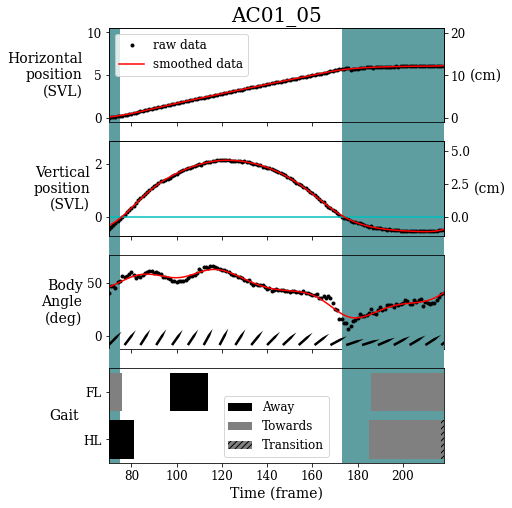

In [71]:
ax, fig = g.graph_all('AC01_05', 'frame', (6, 8), segment=True, clip=True)

In [73]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig.savefig('Figures/AC05_strictjmpsec.pdf', transparent =True, bbox_inches="tight")

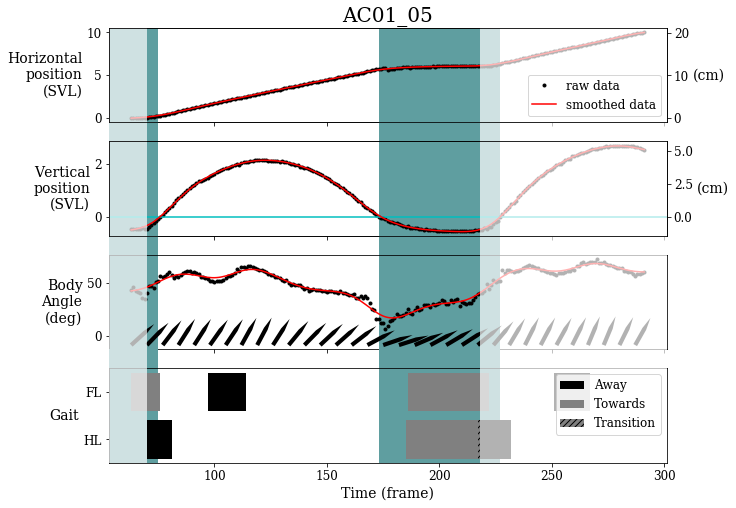

In [10]:
ax, fig = g.graph_all('AC01_05', 'frame', (10, 8), segment=True)

In [15]:
data = g.loadSingleFrog_wsmoothed('AC01_05')
print(data['fps'])
print(data['pxSVL'])

500
109.45465850830078


In [16]:
print('Water contact frames:', data['frameno'][data['watercontactIdx']])
print('FL towards:', data['FL_t'])
print('Propulsion frames:', data['HL_a'])
print('Prep. frames:', data['HL_t'])
print('Index water contact:', data['watercontactIdx'])

Water contact frames: [ 75 173 227]
FL towards: [(63, 13), (186, 36)]
Propulsion frames: [(70, 11), (218, 14)]
Prep. frames: [(185, 32)]
Index water contact: (array([ 12, 110, 164]),)


In [68]:
def above_below_water_range(data, jmp_strict_def = False):
    above = []
    below = []
    #these are the index of water contact
    wc_idx = data['watercontactIdx'][0].flatten()
    #we want to auto-generate each range and check if it the y value > 0
    ####print(wc_idx, len(wc_idx))
    
    #jmp_strict_def if True will only return the ranges included in the
    # strinct jump definition (HL_a to HL_a)
    [(HL_a_fr_s, _), (HL_a_fr_end, _)] = data['HL_a']
    HL_a_idx_start = list(data['frameno']).index(HL_a_fr_s)
    HL_a_idx_end = list(data['frameno']).index(HL_a_fr_end)
    ##print(HL_a_idx_start, HL_a_idx_end)
    
    for i in range(len(wc_idx) + 1):
        ##print(i)
        if i == 0: #first value
            startidx = 0
            endidx = wc_idx[i]
        elif i == (len(wc_idx)):# last value
            startidx = wc_idx[i-1]
            endidx = -1
        else: #middle value
            startidx = wc_idx[i-1]
            endidx = wc_idx[i]
        thesum= np.sum(data['s_mnty'][startidx:endidx])
        ##print('%d:%d --- %s' %(startidx, endidx, thesum > 0))
        
        if jmp_strict_def:
            #Before the segment, skip this range:
            if endidx < HL_a_idx_start:
                continue
            #After the segnebtm skip this rangeL
            if startidx > HL_a_idx_end:
                continue
            if startidx < HL_a_idx_start:
                startidx = HL_a_idx_start
            if endidx > HL_a_idx_end:
                endidx = HL_a_idx_end
               
        if thesum > 0:
            above += [(startidx, endidx)]
        else:
            below += [(startidx, endidx)]
    return above, below

In [18]:
s_mnty = data['s_mnty']
s_mntx = data['s_mntx']
s_mnta = data['s_mnta']
aboveidx, belowidx = above_below_water_range(data, True)

(aboveidx_s, aboveidx_e) = aboveidx[0]
(b4_belowidx_s, b4_belowidx_e) = belowidx[0]
(af_belowidx_s, af_belowidx_e) = belowidx[1]

print('RANGE')
print('b4 jmp Underwater range: %f' %(s_mntx[b4_belowidx_e] - s_mntx[b4_belowidx_s]))
print('after jmp Underwater range: %f' %(s_mntx[af_belowidx_e] - s_mntx[af_belowidx_s]))

print('\nHEIGHT')
print('b4 jmp Underwater height: %f' %np.min(s_mnty[b4_belowidx_s:b4_belowidx_e]))
print('after jmp Underwater height: %f' %np.min(s_mnty[af_belowidx_s:af_belowidx_e]))

print('\nANGLE')
print('b4 jmp underwater angle %f'%(np.mean(s_mnta[b4_belowidx_s:b4_belowidx_e])))
print('after jmp underwater angle %f'%(np.mean(s_mnta[af_belowidx_s:af_belowidx_e])))

RANGE
b4 jmp Underwater range: 18.352077
after jmp Underwater range: 52.768198

HEIGHT
b4 jmp Underwater height: -37.242273
after jmp Underwater height: -62.447277

ANGLE
b4 jmp underwater angle 47.688230
after jmp underwater angle 26.548743


Above water Horiz distance =
581.9746724822587
Above water Height
[231.85585434]
Actual range : 584.374943
Actual height: 232.584205

Avg angle above water surface: 50.088874


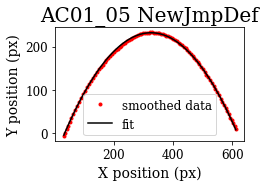

In [19]:
# Inferring jump stats
# Jump 1
plt.plot(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 'r.', label='smoothed data')
plt.title('AC01_05 NewJmpDef')
jmp1_fit = np.polyfit(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 2)
jmp1_fit_poly = np.poly1d(jmp1_fit)
plt.plot(s_mntx[aboveidx_s:aboveidx_e], jmp1_fit_poly(s_mntx[aboveidx_s:aboveidx_e]), 'k-', label='fit')
plt.xlabel('X position (px)')
plt.ylabel('Y position (px)')
plt.legend()

print('Above water Horiz distance =')
roots = jmp1_fit_poly.roots
print(np.abs(roots[0] - roots[1]))

print('Above water Height')
print(jmp1_fit_poly(jmp1_fit_poly.deriv().roots))

print("Actual range : %f" %(s_mntx[aboveidx_e] - s_mntx[aboveidx_s]))
print('Actual height: %f' %np.max(s_mnty[aboveidx_s:aboveidx_e]))

print("\nAvg angle above water surface: %f" %np.mean(s_mnta[aboveidx_s:aboveidx_e]))

In [155]:
print(data['watercontactIdx'])
print(b4_belowidx_e, aboveidx_s)
print(aboveidx_e, af_belowidx_s)
#Body Angles at water contct:
print('Body Angle at water contact: %f, %f' %(s_mnta[b4_belowidx_e], s_mnta[aboveidx_e]))


(array([ 12, 110, 164]),)
12 12
110 110
Body Angle at water contact: 50.660018, 20.860298


In [13]:
def get_position_stats(data):
    

    print(data['fn'])
    print('FPS: %f' %data['fps'])
    print('pxSVL: %f '% data['pxSVL'])

    #print('\nWater contact frames:', data['frameno'][data['watercontactIdx']])
    print('FL towards:', data['FL_t'])
    print('Propulsion frames:', data['HL_a'])
    print('Prep. frames:', data['HL_t'])
    #print('Index water contact:', data['watercontactIdx'])
    aboveidx, belowidx = above_below_water_range(data, True)
    
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    
    print('Water exit frame: %d' %data['frameno'][aboveidx_s])
    print('Water land frame: %d' %data['frameno'][aboveidx_e])

    print('\nRANGE')
    print('b4 jmp Underwater range: %f' %(s_mntx[b4_belowidx_e] - s_mntx[b4_belowidx_s]))
    print('after jmp Underwater range: %f' %(s_mntx[af_belowidx_e] - s_mntx[af_belowidx_s]))

    print('\nHEIGHT')
    print('b4 jmp Underwater height: %f' %np.min(s_mnty[b4_belowidx_s:b4_belowidx_e]))
    print('after jmp Underwater height: %f' %np.min(s_mnty[af_belowidx_s:af_belowidx_e]))

    print('\nANGLE')
    print('b4 jmp underwater angle %f'%(np.mean(s_mnta[b4_belowidx_s:b4_belowidx_e])))
    print('after jmp underwater angle %f'%(np.mean(s_mnta[af_belowidx_s:af_belowidx_e])))

    # Inferring jump stats
    # Jump 1
    fig2 = plt.plot(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 'r.', label='smoothed data')
    ##plt.title('AC01_05 NewJmpDef')
    jmp1_fit = np.polyfit(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 2)
    jmp1_fit_poly = np.poly1d(jmp1_fit)
    plt.plot(s_mntx[aboveidx_s:aboveidx_e], jmp1_fit_poly(s_mntx[aboveidx_s:aboveidx_e]), 'k-', label='fit')
    plt.xlabel('X position (px)')
    plt.ylabel('Y position (px)')
    plt.legend()
    plt.show()
    plt.show()

    print('Above water Horiz distance =')
    roots = jmp1_fit_poly.roots
    print(np.abs(roots[0] - roots[1]))

    print('Above water Height')
    print(jmp1_fit_poly(jmp1_fit_poly.deriv().roots))

    print("Actual range : %f" %(s_mntx[aboveidx_e] - s_mntx[aboveidx_s]))
    print('Actual height: %f' %np.max(s_mnty[aboveidx_s:aboveidx_e]))

    print("\nAvg angle above water surface: %f" %np.mean(s_mnta[aboveidx_s:aboveidx_e]))

    #Body Angles at water contct:
    print('Body Angle at water contact: %f, %f' %(s_mnta[b4_belowidx_e], s_mnta[aboveidx_e]))

In [24]:
frog

'AC04_03'

# Try to do all metrics with new functionality!!!!!!!!1

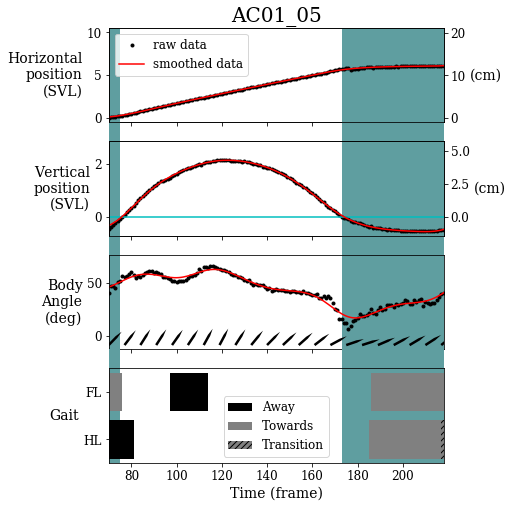

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 01 05_000000/scaled
FPS: 500.000000
pxSVL: 109.454659 
FL towards: [(63, 13), (186, 36)]
Propulsion frames: [(70, 11), (218, 14)]
Prep. frames: [(185, 32)]
Water exit frame: 75
Water land frame: 173

RANGE
b4 jmp Underwater range: 18.352077
after jmp Underwater range: 52.768198

HEIGHT
b4 jmp Underwater height: -37.242273
after jmp Underwater height: -62.447277

ANGLE
b4 jmp underwater angle 47.688230
after jmp underwater angle 26.548743


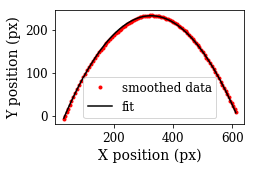

Above water Horiz distance =
581.9746724822587
Above water Height
[231.85585434]
Actual range : 584.374943
Actual height: 232.584205

Avg angle above water surface: 50.088874
Body Angle at water contact: 50.660018, 20.860298
----------------------------------------------



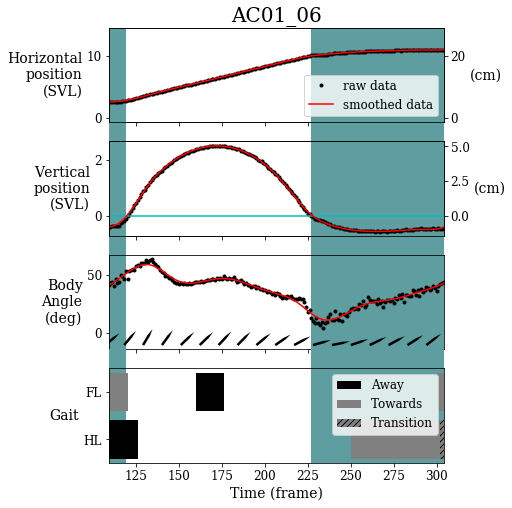

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 01 06_000000/scaled
FPS: 500.000000
pxSVL: 92.387000 
FL towards: [(99, 21), (300, 13)]
Propulsion frames: [(109, 17), (304, 13)]
Prep. frames: [(84, 23), (250, 52)]
Water exit frame: 119
Water land frame: 227

RANGE
b4 jmp Underwater range: 23.097977
after jmp Underwater range: 90.713124

HEIGHT
b4 jmp Underwater height: -38.431704
after jmp Underwater height: -52.573140

ANGLE
b4 jmp underwater angle 45.566204
after jmp underwater angle 25.425730


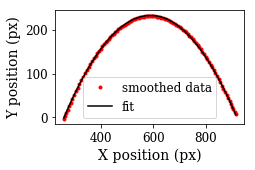

Above water Horiz distance =
660.4502916939803
Above water Height
[232.86142412]
Actual range : 661.324307
Actual height: 231.674277

Avg angle above water surface: 43.320038
Body Angle at water contact: 51.245615, 16.680122
----------------------------------------------



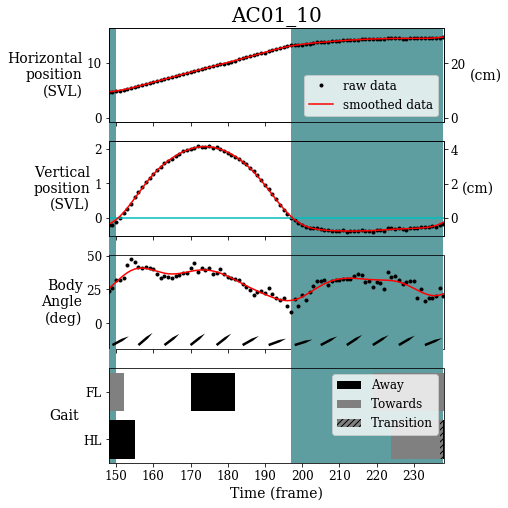

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 01 10_000000/scaled
FPS: 250.000000
pxSVL: 78.758538 
FL towards: [(141, 11), (219, 23)]
Propulsion frames: [(148, 7), (238, 6)]
Prep. frames: [(106, 41), (224, 13)]
Water exit frame: 150
Water land frame: 197

RANGE
b4 jmp Underwater range: 11.880640
after jmp Underwater range: 127.558355

HEIGHT
b4 jmp Underwater height: -14.940107
after jmp Underwater height: -30.579622

ANGLE
b4 jmp underwater angle 26.721839
after jmp underwater angle 27.527812


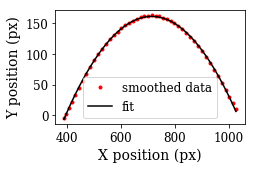

Above water Horiz distance =
637.0275347961988
Above water Height
[161.50836466]
Actual range : 646.480562
Actual height: 163.056699

Avg angle above water surface: 32.949125
Body Angle at water contact: 30.504450, 16.814773
----------------------------------------------



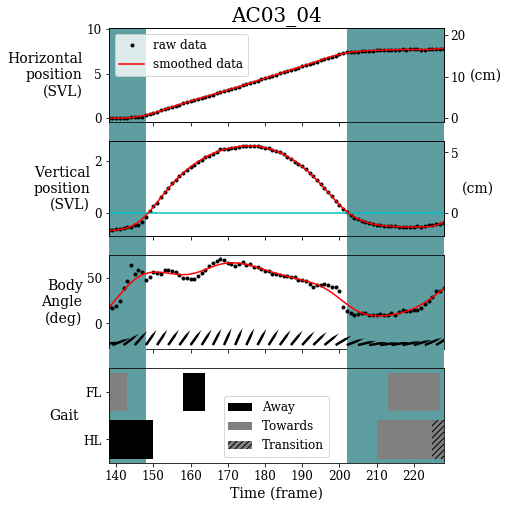

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 4_000000/scaled
FPS: 250.000000
pxSVL: 102.045346 
FL towards: [(127, 16), (213, 14)]
Propulsion frames: [(138, 12), (228, 6)]
Prep. frames: [(127, 8), (210, 15)]
Water exit frame: 148
Water land frame: 202

RANGE
b4 jmp Underwater range: 34.514278
after jmp Underwater range: 53.295964

HEIGHT
b4 jmp Underwater height: -69.848653
after jmp Underwater height: -55.487342

ANGLE
b4 jmp underwater angle 37.244899
after jmp underwater angle 15.780241


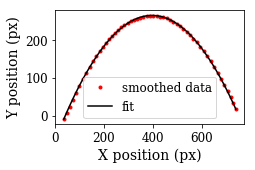

Above water Horiz distance =
709.4444259213187
Above water Height
[265.34798172]
Actual range : 712.212551
Actual height: 263.913803

Avg angle above water surface: 53.747872
Body Angle at water contact: 54.935321, 21.117440
----------------------------------------------



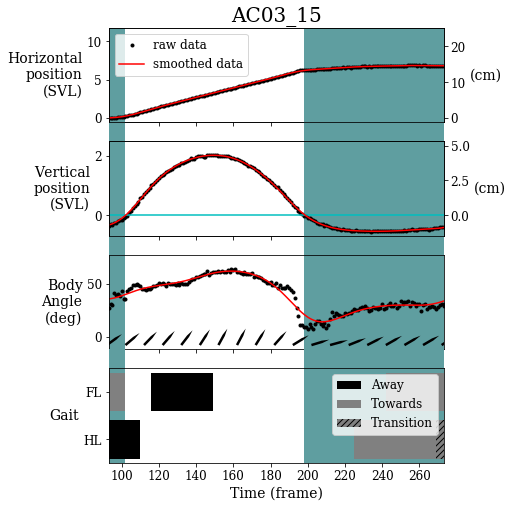

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 15_000000/scaled
FPS: 500.000000
pxSVL: 105.265898 
FL towards: [(62, 40), (242, 44)]
Propulsion frames: [(93, 17), (273, 21)]
Prep. frames: [(62, 23), (225, 44)]
Water exit frame: 102
Water land frame: 198

RANGE
b4 jmp Underwater range: 24.076406
after jmp Underwater range: 65.005577

HEIGHT
b4 jmp Underwater height: -34.372413
after jmp Underwater height: -56.200804

ANGLE
b4 jmp underwater angle 37.602374
after jmp underwater angle 25.132750


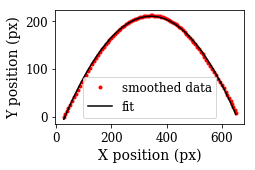

Above water Horiz distance =
621.8534820663025
Above water Height
[210.35802957]
Actual range : 625.119049
Actual height: 212.035651

Avg angle above water surface: 51.053788
Body Angle at water contact: 40.325637, 21.432979
----------------------------------------------



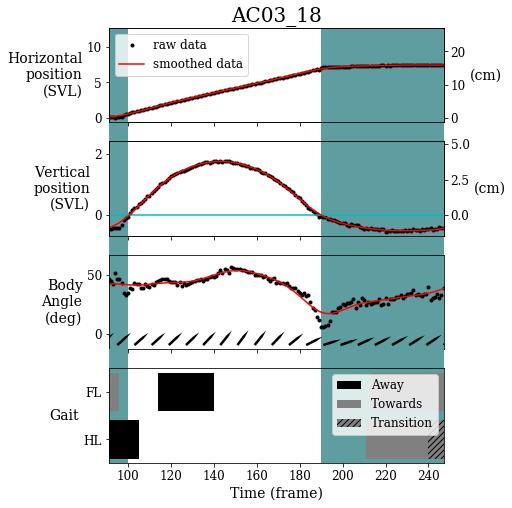

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 18_000000/scaled
FPS: 500.000000
pxSVL: 89.250502 
FL towards: [(73, 23), (213, 40)]
Propulsion frames: [(91, 14), (247, 16)]
Prep. frames: [(60, 20), (211, 29)]
Water exit frame: 100
Water land frame: 190

RANGE
b4 jmp Underwater range: 37.185894
after jmp Underwater range: 46.898911

HEIGHT
b4 jmp Underwater height: -36.737300
after jmp Underwater height: -45.347360

ANGLE
b4 jmp underwater angle 41.912005
after jmp underwater angle 27.370503


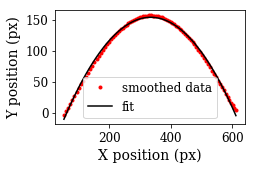

Above water Horiz distance =
546.2261432203867
Above water Height
[154.30744461]
Actual range : 563.403060
Actual height: 157.288086

Avg angle above water surface: 43.390634
Body Angle at water contact: 41.330889, 18.208605
----------------------------------------------



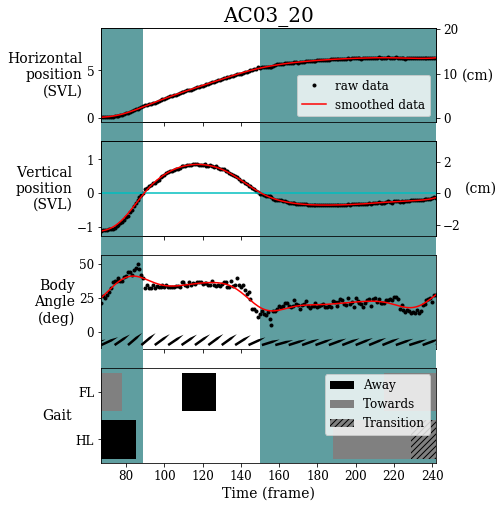

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 20_000000/scaled
FPS: 500.000000
pxSVL: 110.340639 
FL towards: [(59, 19), (215, 35)]
Propulsion frames: [(67, 18), (242, 15)]
Prep. frames: [(32, 25), (188, 41)]
Water exit frame: 89
Water land frame: 150

RANGE
b4 jmp Underwater range: 120.467988
after jmp Underwater range: 118.800418

HEIGHT
b4 jmp Underwater height: -123.495571
after jmp Underwater height: -38.885787

ANGLE
b4 jmp underwater angle 36.013460
after jmp underwater angle 19.950326


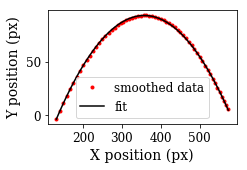

Above water Horiz distance =
443.923852516149
Above water Height
[93.66161679]
Actual range : 447.732671
Actual height: 93.699816

Avg angle above water surface: 33.277995
Body Angle at water contact: 39.422690, 18.050253
----------------------------------------------



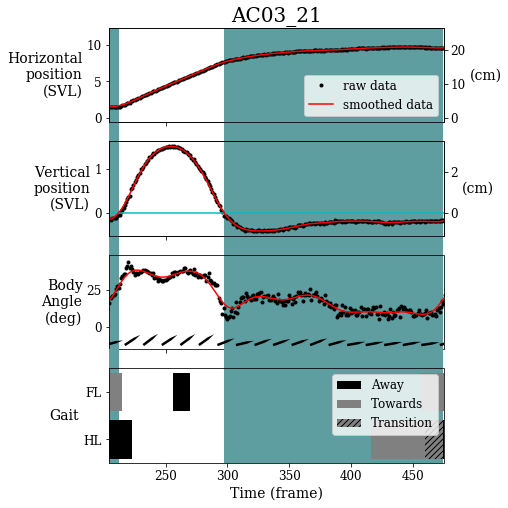

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 21_000000/scaled
FPS: 500.000000
pxSVL: 96.065096 
FL towards: [(185, 30), (456, 30)]
Propulsion frames: [(204, 19), (475, 20)]
Prep. frames: [(137, 56), (416, 44)]
Water exit frame: 212
Water land frame: 297

RANGE
b4 jmp Underwater range: 14.595017
after jmp Underwater range: 190.477295

HEIGHT
b4 jmp Underwater height: -14.610600
after jmp Underwater height: -40.241873

ANGLE
b4 jmp underwater angle 21.808209
after jmp underwater angle 14.248367


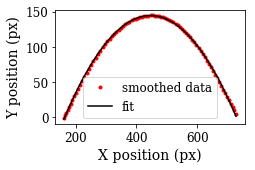

Above water Horiz distance =
563.9234063992365
Above water Height
[144.94292096]
Actual range : 569.856531
Actual height: 145.146393

Avg angle above water surface: 33.361854
Body Angle at water contact: 27.234064, 15.821628
----------------------------------------------



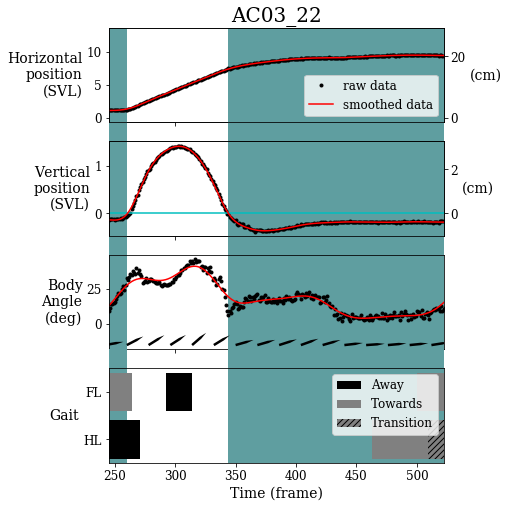

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 22_000000/scaled
FPS: 500.000000
pxSVL: 94.061775 
FL towards: [(228, 36), (500, 37)]
Propulsion frames: [(245, 26), (522, 24)]
Prep. frames: [(160, 77), (463, 46)]
Water exit frame: 260
Water land frame: 344

RANGE
b4 jmp Underwater range: 20.665645
after jmp Underwater range: 191.782013

HEIGHT
b4 jmp Underwater height: -13.383369
after jmp Underwater height: -34.640105

ANGLE
b4 jmp underwater angle 19.826182
after jmp underwater angle 11.570492


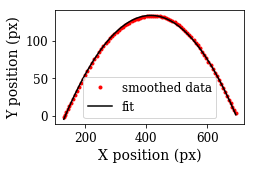

Above water Horiz distance =
560.8943858891403
Above water Height
[133.86350509]
Actual range : 568.835927
Actual height: 133.591188

Avg angle above water surface: 33.256422
Body Angle at water contact: 27.544499, 19.283003
----------------------------------------------



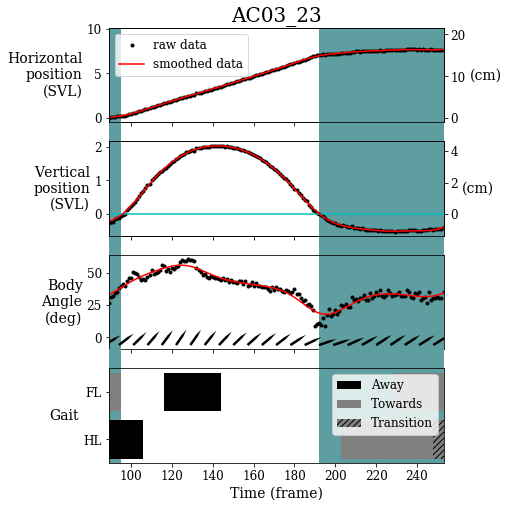

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 03 23_000000/scaled
FPS: 500.000000
pxSVL: 111.731253 
FL towards: [(66, 29), (229, 33)]
Propulsion frames: [(89, 17), (253, 16)]
Prep. frames: [(47, 27), (203, 45)]
Water exit frame: 95
Water land frame: 192

RANGE
b4 jmp Underwater range: 16.925419
after jmp Underwater range: 76.746238

HEIGHT
b4 jmp Underwater height: -24.618256
after jmp Underwater height: -56.602618

ANGLE
b4 jmp underwater angle 35.272539
after jmp underwater angle 28.885606


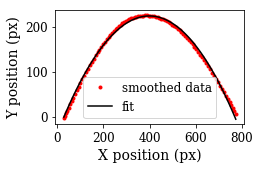

Above water Horiz distance =
739.6072766803295
Above water Height
[224.22339111]
Actual range : 749.590160
Actual height: 225.358645

Avg angle above water surface: 43.387657
Body Angle at water contact: 38.539680, 18.882427
----------------------------------------------



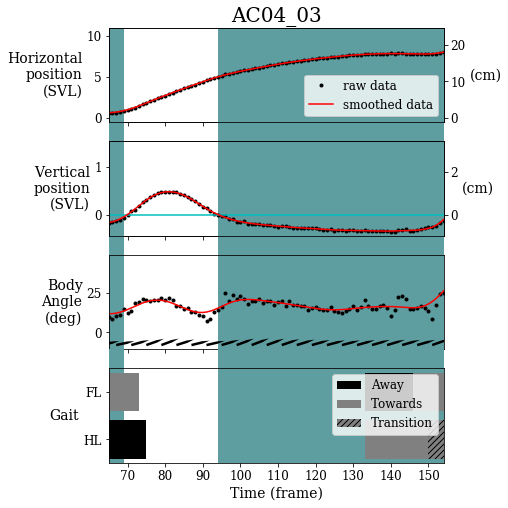

/media/talcat/data/Acris spp/2013_10_31/2013-10-31 AC 04 3_000000/scaled
FPS: 250.000000
pxSVL: 110.860816 
FL towards: [(61, 12), (146, 10)]
Propulsion frames: [(65, 10), (154, 6)]
Prep. frames: [(45, 20), (133, 17)]
Water exit frame: 69
Water land frame: 94

RANGE
b4 jmp Underwater range: 27.464471
after jmp Underwater range: 333.159024

HEIGHT
b4 jmp Underwater height: -18.468371
after jmp Underwater height: -37.914078

ANGLE
b4 jmp underwater angle 12.224029
after jmp underwater angle 17.253667


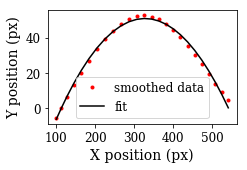

Above water Horiz distance =
429.35737940114154
Above water Height
[51.09020719]
Actual range : 456.960450
Actual height: 52.826480

Avg angle above water surface: 16.509101
Body Angle at water contact: 13.597005, 15.374451
----------------------------------------------



In [49]:
for frog in strict_jump_list:
    ax, fig = g.graph_all(frog, 'frame', (6, 8), segment=True, clip=True)
    plt.show()
    data = g.loadSingleFrog_wsmoothed(frog)

    get_position_stats(data)
    
    print('----------------------------------------------\n')

## Okay lets actual spit them out in an easily copyable format?

In [136]:
sprdsht = pd.DataFrame(columns = ['ID', 'frog', 'SVL(cm)', 'fps', 'px/SVL', 
                                  'frameWaterExit','frameWaterLand', 'frameDurationAboveWater', 'secDurationAboveWater', 
                                  'frameDurationBelowWater_before', 'secDurationBelowWater_before',
                                  'frameDurationBelowWater_after', 'secDurationBelowWater_after',
                                  'AboveWaterActualHeight_px', 'AboveWaterActualHeight_cm',
                                  'AboveWaterActualRange_px', 'AboveWaterActualRange_cm',
                                  'AboveWaterFitHeight_px', 'AboveWaterFitHeight_cm',
                                  'AboveWaterFitRange_px', 'AboveWaterFitRange_cm',
                                  'BAatWC_launch', 'BAatWC_land', 
                                  'framePropStart', 'frameDurationProp', 'secDurationProp',
                                  'framePrepStart', 'frameDurationPrep', 'secDurationPrep',
                                  'BelowWaterRange_before_px', 'BelowWaterRange_before_cm',
                                  'BelowWaterRange_after_px', 'BelowWaterRange_after_cm',
                                  'MaxHeightBelowWater_before_px', 'MaxHeightBelowWater_before_cm',
                                  'MaxHeightBelowWater_after_px', 'MaxHeightBelowWater_after_cm',
                                  'BelowWater_BA_PrepStart', 'BelowWater_BA_PrepEnd',
                                  'AVG_BelowWater_BA_before', 'AVG_AboveWater_BA','AVG_BelowWater_BA_after' 
                                 ])

In [137]:
sprdsht

,ID,frog,SVL(cm),fps,px/SVL,frameWaterExit,frameWaterLand,frameDurationAboveWater,secDurationAboveWater,frameDurationBelowWater_before,secDurationBelowWater_before,frameDurationBelowWater_after,secDurationBelowWater_after,AboveWaterActualHeight_px,AboveWaterActualHeight_cm,AboveWaterActualRange_px,AboveWaterActualRange_cm,AboveWaterFitHeight_px,AboveWaterFitHeight_cm,AboveWaterFitRange_px,AboveWaterFitRange_cm,BAatWC_launch,BAatWC_land,framePropStart,frameDurationProp,secDurationProp,framePrepStart,frameDurationPrep,secDurationPrep,BelowWaterRange_before_px,BelowWaterRange_before_cm,BelowWaterRange_after_px,BelowWaterRange_after_cm,MaxHeightBelowWater_before_px,MaxHeightBelowWater_before_cm,MaxHeightBelowWater_after_px,MaxHeightBelowWater_after_cm,BelowWater_BA_PrepStart,BelowWater_BA_PrepEnd,AVG_BelowWater_BA_before,AVG_AboveWater_BA,AVG_BelowWater_BA_after


In [66]:
data.keys()

dict_keys(['mntx', 'mnta', 'elly', 's_mnty', 'ellx', 'fn', 'ella', 's_mnta', 'FL_a', 'time', 'ellw', 'mnty', 'fps', 'FL_t', 'frogsize(cm)', 'HL_t', 's_mntx', 'HL_a', 'height', 'o_mnty', 'ellh', 'pxSVL', 'watercontactIdx', 'width', 'waterlevel', 'frameno'])

In [9]:
def get_position_stats_dict(data):
    
    returnDict = {}

    #print(data['fn'])
    #print('FPS: %f' %data['fps'])
    returnDict['fps'] = data['fps']
    #print('pxSVL: %f '% data['pxSVL'])
    returnDict['px/SVL'] = data['pxSVL']
    returnDict['SVL(cm)'] = data['frogsize(cm)']

    #print('\nWater contact frames:', data['frameno'][data['watercontactIdx']])
    #print('FL towards:', data['FL_t'])
    
    #print('Propulsion frames:', data['HL_a'])
    [(HL_a_fr_s, HL_a_fr_d), (_,_)] = data['HL_a']
    returnDict['framePropStart'] = HL_a_fr_s
    returnDict['frameDurationProp'] = HL_a_fr_d
    returnDict['secDurationProp'] = returnDict['frameDurationProp']/returnDict['fps']
    
    
    aboveidx, belowidx = above_below_water_range(data, True)
    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    
    
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    #print('Prep. frames:', data['HL_t'])
    for prep in data['HL_t']:
        #print(prep)
        #print(data['frameno'][af_belowidx_s], )
        (prep_fr_s, prep_fr_d) = prep
        if prep_fr_s > data['frameno'][af_belowidx_s] and prep_fr_s < data['frameno'][af_belowidx_e]:
            returnDict['framePrepStart'] = prep_fr_s
            returnDict['frameDurationPrep'] = prep_fr_d
            returnDict['secDurationPrep'] = returnDict['frameDurationPrep']/returnDict['fps']
            
            returnDict['BelowWater_BA_PrepStart'] = s_mnta[list(data['frameno']).index(returnDict['framePrepStart'])]
            returnDict['BelowWater_BA_PrepEnd'] = s_mnta[list(data['frameno']).index(returnDict['framePrepStart'] + returnDict['frameDurationPrep'])]
    


    
    #print('Water exit frame: %d' %data['frameno'][aboveidx_s])
    returnDict['frameWaterExit'] = data['frameno'][aboveidx_s]
    #print('Water land frame: %d' %data['frameno'][aboveidx_e])
    returnDict['frameWaterLand'] = data['frameno'][aboveidx_e]
    returnDict['frameDurationAboveWater'] = returnDict['frameWaterLand'] - returnDict['frameWaterExit']
    returnDict['secDurationAboveWater'] = returnDict['frameDurationAboveWater']/returnDict['fps']
    
    returnDict['frameDurationBelowWater_before'] = returnDict['frameWaterExit'] - returnDict['framePropStart']
    returnDict['secDurationBelowWater_before'] = returnDict['frameDurationBelowWater_before']/returnDict['fps']
    
    returnDict['frameDurationBelowWater_after'] = returnDict['framePrepStart'] + returnDict['frameDurationPrep'] - returnDict['frameWaterLand']
    returnDict['secDurationBelowWater_after'] = returnDict['frameDurationBelowWater_after']/returnDict['fps']

    #print('\nRANGE')
    #print('b4 jmp Underwater range: %f' %(s_mntx[b4_belowidx_e] - s_mntx[b4_belowidx_s]))
    returnDict['BelowWaterRange_before_px'] = (s_mntx[b4_belowidx_e] - s_mntx[b4_belowidx_s])
    returnDict['BelowWaterRange_before_cm'] = returnDict['BelowWaterRange_before_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
    #print('after jmp Underwater range: %f' %(s_mntx[af_belowidx_e] - s_mntx[af_belowidx_s]))
    returnDict['BelowWaterRange_after_px'] = (s_mntx[af_belowidx_e] - s_mntx[af_belowidx_s])
    returnDict['BelowWaterRange_after_cm'] = returnDict['BelowWaterRange_after_px']/returnDict['px/SVL']*returnDict['SVL(cm)']

    
    #print('\nHEIGHT')
    #print('b4 jmp Underwater height: %f' %np.min(s_mnty[b4_belowidx_s:b4_belowidx_e]))
    returnDict['MaxHeightBelowWater_before_px'] = -1*np.min(s_mnty[b4_belowidx_s:b4_belowidx_e])
    returnDict['MaxHeightBelowWater_before_cm'] = returnDict['MaxHeightBelowWater_before_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
    #print('after jmp Underwater height: %f' %np.min(s_mnty[af_belowidx_s:af_belowidx_e]))
    returnDict['MaxHeightBelowWater_after_px'] = -1*np.min(s_mnty[af_belowidx_s:af_belowidx_e])
    returnDict['MaxHeightBelowWater_after_cm'] = returnDict['MaxHeightBelowWater_after_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
    
    #print('\nANGLE')
    #print('b4 jmp underwater angle %f'%(np.mean(s_mnta[b4_belowidx_s:b4_belowidx_e])))
    returnDict['AVG_BelowWater_BA_before'] = (np.mean(s_mnta[b4_belowidx_s:b4_belowidx_e]))
    #print('after jmp underwater angle %f'%(np.mean(s_mnta[af_belowidx_s:af_belowidx_e])))
    returnDict['AVG_BelowWater_BA_after'] = (np.mean(s_mnta[af_belowidx_s:af_belowidx_e]))
    
    # Inferring jump stats
    # Jump 1
    #fig2 = plt.plot(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 'r.', label='smoothed data')
    ##plt.title('AC01_05 NewJmpDef')
    jmp1_fit = np.polyfit(s_mntx[aboveidx_s:aboveidx_e], s_mnty[aboveidx_s:aboveidx_e], 2)
    jmp1_fit_poly = np.poly1d(jmp1_fit)
    #plt.plot(s_mntx[aboveidx_s:aboveidx_e], jmp1_fit_poly(s_mntx[aboveidx_s:aboveidx_e]), 'k-', label='fit')
    #plt.xlabel('X position (px)')
    #plt.ylabel('Y position (px)')
    #plt.legend()
    #plt.show()
    #plt.show()

    #print('Above water Horiz distance =')
    roots = jmp1_fit_poly.roots
    #print(np.abs(roots[0] - roots[1]))
    returnDict['AboveWaterFitRange_px'] = np.abs(roots[0] - roots[1])
    returnDict['AboveWaterFitRange_cm'] = returnDict['AboveWaterFitRange_px']/returnDict['px/SVL']*returnDict['SVL(cm)']

    #print('Above water Height')
    #print(jmp1_fit_poly(jmp1_fit_poly.deriv().roots))
    returnDict['AboveWaterFitHeight_px'] = jmp1_fit_poly(jmp1_fit_poly.deriv().roots)[0]
    returnDict['AboveWaterFitHeight_cm'] = returnDict['AboveWaterFitHeight_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
    
    #print("Actual range : %f" %(s_mntx[aboveidx_e] - s_mntx[aboveidx_s]))
    returnDict['AboveWaterActualRange_px'] = (s_mntx[aboveidx_e] - s_mntx[aboveidx_s])
    returnDict['AboveWaterActualRange_cm'] = returnDict['AboveWaterActualRange_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
    #print('Actual height: %f' %np.max(s_mnty[aboveidx_s:aboveidx_e]))
    returnDict['AboveWaterActualHeight_px'] = np.max(s_mnty[aboveidx_s:aboveidx_e])
    returnDict['AboveWaterActualHeight_cm'] = returnDict['AboveWaterActualHeight_px']/returnDict['px/SVL']*returnDict['SVL(cm)']
               
    #print("\nAvg angle above water surface: %f" %np.mean(s_mnta[aboveidx_s:aboveidx_e]))
    returnDict['AVG_AboveWater_BA'] = np.mean(s_mnta[aboveidx_s:aboveidx_e])
    
    #Body Angles at water contct:
    #print('Body Angle at water contact: %f, %f' %(s_mnta[b4_belowidx_e], s_mnta[aboveidx_e]))
    returnDict['BAatWC_launch'] = (s_mnta[b4_belowidx_e])
    returnDict['BAatWC_land'] = s_mnta[aboveidx_e]
    
    return returnDict

In [139]:
for i, frog in enumerate(strict_jump_list):
    data = g.loadSingleFrog_wsmoothed(frog)

    newrow = get_position_stats_dict(data)
    newrow['ID'] = frog
    newrow['frog'] = newrow['ID'][:4]
    #print(newrow.keys())
    #print(sprdsht.columns)
    sprdsht.loc[i] = newrow


In [140]:
pd.set_option('display.max_columns', None)

In [141]:
sprdsht

,ID,frog,SVL(cm),fps,px/SVL,frameWaterExit,frameWaterLand,frameDurationAboveWater,secDurationAboveWater,frameDurationBelowWater_before,secDurationBelowWater_before,frameDurationBelowWater_after,secDurationBelowWater_after,AboveWaterActualHeight_px,AboveWaterActualHeight_cm,AboveWaterActualRange_px,AboveWaterActualRange_cm,AboveWaterFitHeight_px,AboveWaterFitHeight_cm,AboveWaterFitRange_px,AboveWaterFitRange_cm,BAatWC_launch,BAatWC_land,framePropStart,frameDurationProp,secDurationProp,framePrepStart,frameDurationPrep,secDurationPrep,BelowWaterRange_before_px,BelowWaterRange_before_cm,BelowWaterRange_after_px,BelowWaterRange_after_cm,MaxHeightBelowWater_before_px,MaxHeightBelowWater_before_cm,MaxHeightBelowWater_after_px,MaxHeightBelowWater_after_cm,BelowWater_BA_PrepStart,BelowWater_BA_PrepEnd,AVG_BelowWater_BA_before,AVG_AboveWater_BA,AVG_BelowWater_BA_after
0,AC01_05,AC01,2.01,500,109.454659,75,173,98,0.196,5,0.010,44,0.088,232.584205,4.271122,584.374943,10.731326,231.855854,4.257747,581.974672,10.687248,50.660018,20.860298,70,11,0.022,185,32,0.064,18.352077,0.337013,52.768198,0.969023,37.242273,0.683908,62.447277,1.146767,19.784265,39.110359,47.688230,50.088874,26.548743
1,AC01_06,AC01,2.01,500,92.387000,119,227,108,0.216,10,0.020,75,0.150,231.674277,5.040377,661.324307,14.387975,232.861424,5.066205,660.450292,14.368960,51.245615,16.680122,109,17,0.034,250,52,0.104,23.097977,0.502527,90.713124,1.973583,38.431704,0.836132,52.573140,1.143797,18.729854,41.459750,45.566204,43.320038,25.425730
2,AC01_10,AC01,2.01,250,78.758538,150,197,47,0.188,2,0.008,40,0.160,163.056699,4.161377,646.480562,16.498858,161.508365,4.121862,637.027535,16.257607,30.504450,16.814773,148,7,0.028,224,13,0.052,11.880640,0.303206,127.558355,3.255422,14.940107,0.381287,30.579622,0.780424,31.514190,20.819949,26.721839,32.949125,27.527812
3,AC03_04,AC03,2.14,250,102.045346,148,202,54,0.216,10,0.040,23,0.092,263.913803,5.534555,712.212551,14.935859,265.347982,5.564631,709.444426,14.877808,54.935321,21.117440,138,12,0.048,210,15,0.060,34.514278,0.723801,53.295964,1.117673,69.848653,1.464801,55.487342,1.163629,8.177368,28.779610,37.244899,53.747872,15.780241
4,AC03_15,AC03,2.14,500,105.265898,102,198,96,0.192,9,0.018,71,0.142,212.035651,4.310573,625.119049,12.708339,210.358030,4.276467,621.853482,12.641952,40.325637,21.432979,93,17,0.034,225,44,0.088,24.076406,0.489461,65.005577,1.321529,34.372413,0.698773,56.200804,1.142533,23.636299,31.935698,37.602374,51.053788,25.132750
5,AC03_18,AC03,2.14,500,89.250502,100,190,90,0.180,9,0.018,50,0.100,157.288086,3.771368,563.403060,13.508972,154.307445,3.699900,546.226143,13.097113,41.330889,18.208605,91,14,0.028,211,29,0.058,37.185894,0.891623,46.898911,1.124517,36.737300,0.880867,45.347360,1.087314,26.478528,34.252236,41.912005,43.390634,27.370503
6,AC03_20,AC03,2.14,500,110.340639,89,150,61,0.122,22,0.044,79,0.158,93.699816,1.817260,447.732671,8.683545,93.661617,1.816519,443.923853,8.609675,39.422690,18.050253,67,18,0.036,188,41,0.082,120.467988,2.336415,118.800418,2.304073,123.495571,2.395133,38.885787,0.754170,20.598763,17.854594,36.013460,33.277995,19.950326
7,AC03_21,AC03,2.14,500,96.065096,212,297,85,0.170,8,0.016,163,0.326,145.146393,3.233363,569.856531,12.694444,144.942921,3.228830,563.923406,12.562274,27.234064,15.821628,204,19,0.038,416,44,0.088,14.595017,0.325127,190.477295,4.243179,14.610600,0.325474,40.241873,0.896451,10.190704,8.571104,21.808209,33.361854,14.248367
8,AC03_22,AC03,2.14,500,94.061775,260,344,84,0.168,15,0.030,165,0.330,133.591188,3.039334,568.835927,12.941589,133.863505,3.045529,560.894386,12.760911,27.544499,19.283003,245,26,0.052,463,46,0.092,20.665645,0.470164,191.782013,4.363234,13.383369,0.304485,34.640105,0.788097,4.185948,7.705714,19.826182,33.256422,11.570492
9,AC03_23,AC03,2.14,500,111.731253,95,192,97,0.194,6,0.012,56,0.112,225.358645,4.316317,749.590160,14.356976,224.223391,4.294573,739.607277,14.165773,38.539680,18.882427,89,17,0.034,203,45,0.090,16.925419,0.324174,76.746238,1.469

In [71]:
sprdsht.to_clipboard()

In [76]:
### Lets do stats the right way

In [142]:
perfrogavg = sprdsht.groupby('frog').mean().filter(regex='(sec|cm|BA)').add_prefix('AVG_')

In [101]:
perfrogstd = sprdsht.groupby('frog').std().filter(regex='(sec|cm|BA)').add_prefix('STD_')

In [143]:
fullavg = perfrogavg.mean()

In [144]:
fullavg

AVG_SVL(cm)                           2.126667
AVG_secDurationAboveWater             0.159143
AVG_secDurationBelowWater_before      0.018032
AVG_secDurationBelowWater_after       0.178889
AVG_AboveWaterActualHeight_cm         3.090373
AVG_AboveWaterActualRange_cm         11.965813
AVG_AboveWaterFitHeight_cm            3.071137
AVG_AboveWaterFitRange_cm            11.693858
AVG_BAatWC_launch                    32.069937
AVG_BAatWC_land                      17.487918
AVG_secDurationProp                   0.035524
AVG_secDurationPrep                   0.073683
AVG_BelowWaterRange_before_cm         0.575922
AVG_BelowWaterRange_after_cm          3.681780
AVG_MaxHeightBelowWater_before_cm     0.646570
AVG_MaxHeightBelowWater_after_cm      0.924787
AVG_BelowWater_BA_PrepStart          18.530541
AVG_BelowWater_BA_PrepEnd            24.969420
AVG_AVG_BelowWater_BA_before         28.342500
AVG_AVG_AboveWater_BA                33.422636
AVG_AVG_BelowWater_BA_after          21.391395
dtype: float6

In [111]:
fullstd = (sprdsht.groupby('frog').mean().filter(regex='(sec|cm|BA)')).std().add_prefix('STD_')

In [112]:
fullstd.to_clipboard()

# Lets try and Do Velocity metrics here too why not

In [150]:
# Lets test with AC01_05
data = g.loadSingleFrog_wsmoothed('AC01_05')


In [154]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

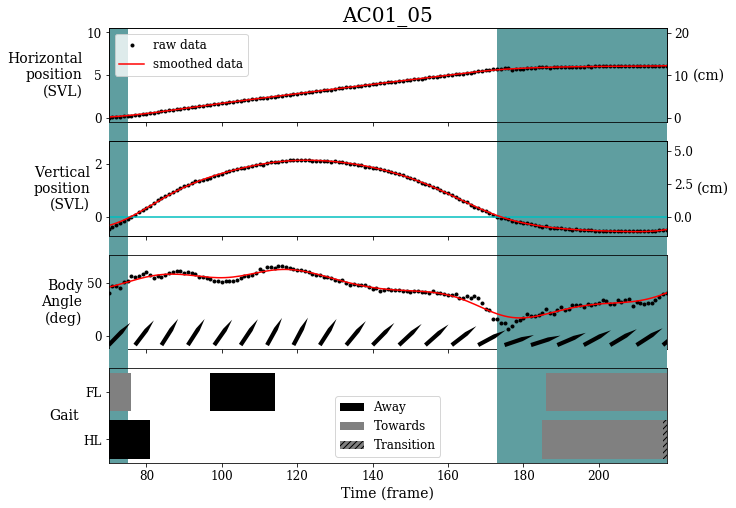

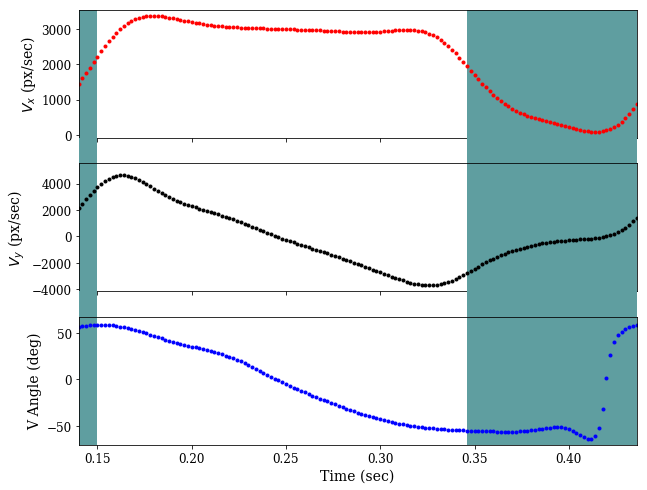

In [156]:
#Step one - we want to do a butterworth filter 
# Turns out I did this to the data already in full lol its just s_mntxy
#so lets just calc the velocity.  We'll do gradiant
v_smntx=np.gradient(s_mntx, data['time'])
v_smnty= np.gradient(s_mnty, data['time'])
v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))


scale = data['frogsize(cm)']

#And plot to see if it looks good
ax2, fig2 = g.graph_all('AC01_05', 'frame', (10, 8), segment=True, clip=True)
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
ax[0].plot(data['time'], v_smntx, 'r.', label='V_x')
ax[0].set_ylabel('$V_{x}$ (px/sec)')

ax[1].plot(data['time'], v_smnty, 'k.', label='V_y')
ax[1].set_ylabel('$V_{y}$ (px/sec)')
ax[2].plot(data['time'], v_angle, 'b.', label='angle')

ax[2].set_ylabel('V Angle (deg)')
ax[2].set_xlabel('Time (sec)')


aboveidx, belowidx = above_below_water_range(data, True)

(aboveidx_s, aboveidx_e) = aboveidx[0]
(b4_belowidx_s, b4_belowidx_e) = belowidx[0]
(af_belowidx_s, af_belowidx_e) = belowidx[1]


## Only dealing with new jump definition rn
fr_thestart = data['HL_a'][0][0]
fr_theend = data['HL_a'][1][0]
indices = [i for i, j in enumerate(data['frameno']) if j == fr_thestart]
if len(indices) == 0:
    thestart = 0
    print("Need to fix beginning data")
else:    
    thestart = indices[0]
indices = [i for i, j in enumerate(data['frameno']) if j == fr_theend]
theend = indices[0]
thetime2 = thetime[thestart:theend+1]
#thetime = thetime - thetime[0]
for axs in ax:
    axs.set_xlim(thetime2[0], thetime2[-1])




water = [0] + list(data['watercontactIdx'][0]) + [len(data['frameno']) - 1]
#print(s_mnty[water])
test = [(water[i], water[i+1]) for i in range(len(water) - 1) if s_mnty[int(np.mean([water[i], water[i+1]]))] < 0]
thetime = data['time']
ftt = 1/data['fps']

for idx, tax in enumerate(ax):             
    for o in test:
        if idx == 0:
            y_max = 1
            y_min = 0
        else:
            y_min = 0
            y_max = 1.2
        if o[0] == 0:
            start = np.array(thetime)[o[0]] - 10*ftt
        else:
            start = np.array(thetime)[o[0]] 
        if o[1] == len(s_mnty) - 1:
            end = np.array(thetime)[o[1]] + 10 *ftt
        else:
            end = np.array(thetime)[o[1]]
            
        if start < thetime2[0]:
            start = thetime2[0]
        if end > thetime2[-1]:
            end = thetime2[-1]

                
               
        tax.axvspan(start, end, ymin = y_min, ymax = y_max, facecolor='cadetblue', alpha = 1, zorder = 0, clip_on=False)

In [113]:
aboveidx, belowidx

([(12, 110)], [(7, 12), (110, 155)])

In [124]:
#Idx of max velocity
MaxVelIdx = np.where(v_smnty == np.max(v_smnty[aboveidx_s:aboveidx_e]))
print('MaxVelIdx: %d' %MaxVelIdx)
#frame of max velocity
MaxVelFr = data['frameno'][MaxVelIdx][0]
print('MaxVelFrame: %d' %MaxVelFr)

#Vx @ Max velocity (px/sec)
MaxVx = v_smntx[MaxVelIdx]
print('Vx @ Max V: %f' %MaxVx)
#Vy @ Max velocity (px/sec)
MaxVy = v_smnty[MaxVelIdx]
print('Vy @ Max V: %f' %MaxVy)
#V @ max velocity (px/sec)
MaxV = np.sqrt(MaxVx**2 + MaxVy**2)
print('V @ Max V: %f' %MaxV)
#V angle @ Max velocity (deg)
MaxVa = v_angle[MaxVelIdx]
print('V angle @ Max V: %f' %MaxVa)
#BA @ max veloctity
BAatMaxV = data['s_mnta'][MaxVelIdx][0]
print('BA @ Max V: %f' %BAatMaxV)


#Avg horizontal velocity above water
AvgHorVelAbove = np.mean(v_smntx[aboveidx_s:aboveidx_e])
print('Above Horizontal Velocity - Above Water: %f' %AvgHorVelAbove)
#avg horizontal velocity below water (b4 jump)
AvgHorVelBelow_before = np.mean(v_smntx[b4_belowidx_s:b4_belowidx_e])
print('Above Horizontal Velocity - Below Water - Before: %f' %AvgHorVelBelow_before)
#Avg horizontal velocity below water (after jump)
AvgHorVelBelow_after = np.mean(v_smntx[af_belowidx_s:af_belowidx_e])
print('Above Horizontal Velocity - Below Water - After: %f' %AvgHorVelBelow_after)
#Avg horizontal velocity entire jump (HL_a to HL_a)
AvgHorVelTotal = np.mean(v_smntx[b4_belowidx_s:af_belowidx_e])
print('Above Horizontal Velocity - Total: %f' %AvgHorVelTotal)




MaxVelIdx: 19
MaxVelFrame: 82
Vx @ Max V: 3097.878004
Vy @ Max V: 4607.640752
V @ Max V: 5552.224908
V angle @ Max V: 56.085680
BA @ Max V: 56.725713
Above Horizontal Velocity - Above Water: 2982.188438
Above Horizontal Velocity - Below Water - Before: 1759.194011
Above Horizontal Velocity - Below Water - After: 599.838706
Above Horizontal Velocity - Total: 2216.507965


## Okay lets do everything at once and in spreadsheet form

In [28]:
Velsprdsht = pd.DataFrame(columns = ['ID','frog', 'MaxVelIdx', 'MaxVel_fr', 
                                     'MaxVx_px/sec', 'MaxVx_cm/sec',
                                     'MaxVy_px/sec', 'MaxVy_cm/sec',
                                     'MaxV_px/sec', 'MaxV_cm/sec',
                                     'MaxV_ang', 'BAatMaxV', 
                                     'AvgHorVelAbove_px/sec', 'AvgHorVelAbove_cm/sec',
                                     'AvgHorVelBelow_before_px/sec', 'AvgHorVelBelow_before_cm/sec',
                                     'AvgHorVelBelow_after_px/sec', 'AvgHorVelBelow_after_cm/sec',
                                     'AvgHorVelTotal_px/sec', 'AvgHorVelTotal_cm/sec'
                                    ])

In [29]:
from scipy import signal

In [30]:
def get_velocity_stats_dict(data):
    
    returnDict = {}
    
    s_mntx = data['s_mntx']
    s_mnty = data['s_mnty']
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print(belowidx)
    
    #Idx of max velocity
    #MaxVelIdx = np.where(v_total == np.max(v_total[aboveidx_s:aboveidx_e]))
    #05/2021: the above gives incorrect place in rare case where velocity has 2 peaks
    peak, k = signal.find_peaks(v_total[b4_belowidx_s:af_belowidx_e], prominence=data['fps'])
    if len(peak) > 0:
        MaxVelIdx = np.where(v_total == v_total[b4_belowidx_s:af_belowidx_e][peak[0]])[0][0]
    else:
         MaxVelIdx= 5   
    #print('MaxVelIdx: %d' %MaxVelIdx)
    returnDict['MaxVelIdx'] = MaxVelIdx

    
    #frame of max velocity
    MaxVelFr = data['frameno'][MaxVelIdx]
    #print('MaxVelFrame: %d' %MaxVelFr)
    returnDict['MaxVel_fr'] = MaxVelFr

    
    #Vx @ Max velocity (px/sec)
    MaxVx = v_smntx[MaxVelIdx]
    #print('Vx @ Max V: %f' %MaxVx)
    returnDict['MaxVx_px/sec'] = MaxVx
    returnDict['MaxVx_cm/sec'] = returnDict['MaxVx_px/sec']/data['pxSVL']*data['frogsize(cm)']
    
    #Vy @ Max velocity (px/sec)
    MaxVy = v_smnty[MaxVelIdx]
    #print('Vy @ Max V: %f' %MaxVy)
    returnDict['MaxVy_px/sec'] = MaxVy
    returnDict['MaxVy_cm/sec'] = returnDict['MaxVy_px/sec']/data['pxSVL']*data['frogsize(cm)']
    
    #V @ max velocity (px/sec)
    MaxV = np.sqrt(MaxVx**2 + MaxVy**2)
    #print('V @ Max V: %f' %MaxV)
    returnDict['MaxV_px/sec'] = MaxV
    returnDict['MaxV_cm/sec'] = returnDict['MaxV_px/sec']/data['pxSVL']*data['frogsize(cm)']

    
    #V angle @ Max velocity (deg)
    MaxVa = v_angle[MaxVelIdx]
    #print('V angle @ Max V: %f' %MaxVa)
    returnDict['MaxV_ang'] = MaxVa

    
    #BA @ max veloctity
    BAatMaxV = data['s_mnta'][MaxVelIdx]
    #print('BA @ Max V: %f' %BAatMaxV)
    returnDict['BAatMaxV'] = BAatMaxV


    
    #Avg horizontal velocity above water
    AvgHorVelAbove = np.mean(v_smntx[aboveidx_s:aboveidx_e])
    #print('Above Horizontal Velocity - Above Water: %f' %AvgHorVelAbove)
    returnDict['AvgHorVelAbove_px/sec'] = AvgHorVelAbove
    returnDict['AvgHorVelAbove_cm/sec'] = returnDict['AvgHorVelAbove_px/sec']/data['pxSVL']*data['frogsize(cm)']

    
    #avg horizontal velocity below water (b4 jump)
    AvgHorVelBelow_before = np.mean(v_smntx[b4_belowidx_s:b4_belowidx_e])
    #print('Above Horizontal Velocity - Below Water - Before: %f' %AvgHorVelBelow_before)
    returnDict['AvgHorVelBelow_before_px/sec'] = AvgHorVelBelow_before
    returnDict['AvgHorVelBelow_before_cm/sec'] = returnDict['AvgHorVelBelow_before_px/sec']/data['pxSVL']*data['frogsize(cm)']
    
    #Avg horizontal velocity below water (after jump)
    AvgHorVelBelow_after = np.mean(v_smntx[af_belowidx_s:af_belowidx_e])
    #print('Above Horizontal Velocity - Below Water - After: %f' %AvgHorVelBelow_after)
    returnDict['AvgHorVelBelow_after_px/sec'] = AvgHorVelBelow_after
    returnDict['AvgHorVelBelow_after_cm/sec'] = returnDict['AvgHorVelBelow_after_px/sec']/data['pxSVL']*data['frogsize(cm)']
    
    #Avg horizontal velocity entire jump (HL_a to HL_a)
    AvgHorVelTotal = np.mean(v_smntx[b4_belowidx_s:af_belowidx_e])
    #print('Above Horizontal Velocity - Total: %f' %AvgHorVelTotal)
    returnDict['AvgHorVelTotal_px/sec'] = AvgHorVelTotal
    returnDict['AvgHorVelTotal_cm/sec'] = returnDict['AvgHorVelTotal_px/sec']/data['pxSVL']*data['frogsize(cm)']


    return returnDict

    

In [31]:
for i, frog in enumerate(strict_jump_list):
    data = g.loadSingleFrog_wsmoothed(frog)

    newrow = get_velocity_stats_dict(data)
    newrow['ID'] = frog
    newrow['frog'] = frog[:4]
    #print(newrow.keys())
    #print(sprdsht.columns)
    Velsprdsht.loc[i] = newrow

[(7, 12), (110, 155)]
[(90, 100), (208, 285)]
[(125, 127), (174, 215)]
[(11, 21), (75, 101)]
[(41, 50), (146, 221)]
[(20, 29), (119, 176)]
[(21, 43), (104, 196)]
[(153, 160), (245, 423)]
[(201, 216), (300, 478)]
[(23, 29), (126, 187)]
[(38, 42), (67, 127)]


In [32]:
Velsprdsht

,ID,frog,MaxVelIdx,MaxVel_fr,MaxVx_px/sec,MaxVx_cm/sec,MaxVy_px/sec,MaxVy_cm/sec,MaxV_px/sec,MaxV_cm/sec,MaxV_ang,BAatMaxV,AvgHorVelAbove_px/sec,AvgHorVelAbove_cm/sec,AvgHorVelBelow_before_px/sec,AvgHorVelBelow_before_cm/sec,AvgHorVelBelow_after_px/sec,AvgHorVelBelow_after_cm/sec,AvgHorVelTotal_px/sec,AvgHorVelTotal_cm/sec
0,AC01_05,AC01,20,83,3175.371269,58.311783,4569.827467,83.919253,5564.737709,102.189555,55.206270,57.228400,2982.188438,54.764218,1759.194011,32.305431,599.838706,11.015299,2216.507965,40.703439
1,AC01_06,AC01,109,128,3415.465507,74.307919,4274.838932,93.004711,5471.713856,119.044291,51.376215,58.727544,3062.332038,66.625038,1059.470519,23.050167,597.145285,12.991677,1986.188473,43.212128
2,AC01_10,AC01,134,157,3598.456519,91.836362,2843.534630,72.569968,4586.346968,117.048356,38.316127,40.758666,3429.849436,87.533333,1289.997757,32.922088,789.360675,20.145307,2179.407852,55.620761
3,AC03_04,AC03,25,152,3464.488677,72.654032,4599.310947,96.452468,5758.154477,120.754656,53.010654,56.242293,3300.388760,69.212681,738.907714,15.495685,523.381185,10.975863,2213.533122,46.420156
4,AC03_15,AC03,60,112,3740.098976,76.034233,3921.153256,79.714971,5418.835964,110.162068,46.353789,46.139306,3258.247571,66.238449,1228.981143,24.984536,444.732420,9.041175,1984.486270,40.343556
5,AC03_18,AC03,36,107,3670.304940,88.004575,3147.698165,75.473794,4835.198247,115.935754,40.616792,41.322035,3133.681016,75.137699,1953.279988,46.834685,429.292149,10.293334,2077.438871,49.811699
6,AC03_20,AC03,41,87,4276.140546,82.933549,3962.674987,76.854045,5829.937480,113.068642,42.821095,40.336714,3685.137961,71.471357,2650.615976,51.407335,654.358423,12.690945,1961.759669,38.047321
7,AC03_21,AC03,174,226,3714.439000,82.744928,2785.041747,62.041153,4642.576290,103.420636,36.862123,37.893723,3346.467398,74.547786,928.141275,20.675796,541.137183,12.054676,1434.330135,31.951943
8,AC03_22,AC03,229,273,3686.952559,83.881879,2681.094884,60.997605,4558.715712,103.715368,36.024068,32.411075,3380.685225,76.913989,625.843914,14.238579,546.138704,12.425205,1410.028545,32.079568
9,AC03_23,AC03,41,107,4112.353695,78.764327,4073.492767,78.020019,5788.332768,110.864523,44.728000,48.619946,3860.542605,73.941363,1299.249232,24.884652,644.008179,12.334754,2570.442847,49.231952


In [75]:
Velsprdsht.to_clipboard()

In [ ]:
# Lets do averages right again

In [134]:
Velperfrogavg = Velsprdsht.groupby('frog').mean().filter(regex='(cm|BA|ang)').add_prefix('AVG_')

In [124]:
Velperfrogavg.to_clipboard()

In [126]:
Velperfrogstd = Velsprdsht.groupby('frog').std().filter(regex='(cm|BA|ang)').add_prefix('STD_')

In [135]:
Velperfrogavg.mean().to_clipboard()

In [133]:
(Velsprdsht.groupby('frog').mean().filter(regex='(cm|BA|ang)')).std().add_prefix('STD_').to_clipboard()

# What do angle comparisons look lito_clipboardyway?

In [10]:
from matplotlib.pyplot import cm

In [11]:
b4time = .018032
abovetime = .159143
aftime = .178889

totaltime = b4time + abovetime + aftime
ratio_b4 = b4time/totaltime
ratio_above = abovetime/totaltime
ratio_af = aftime/totaltime

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


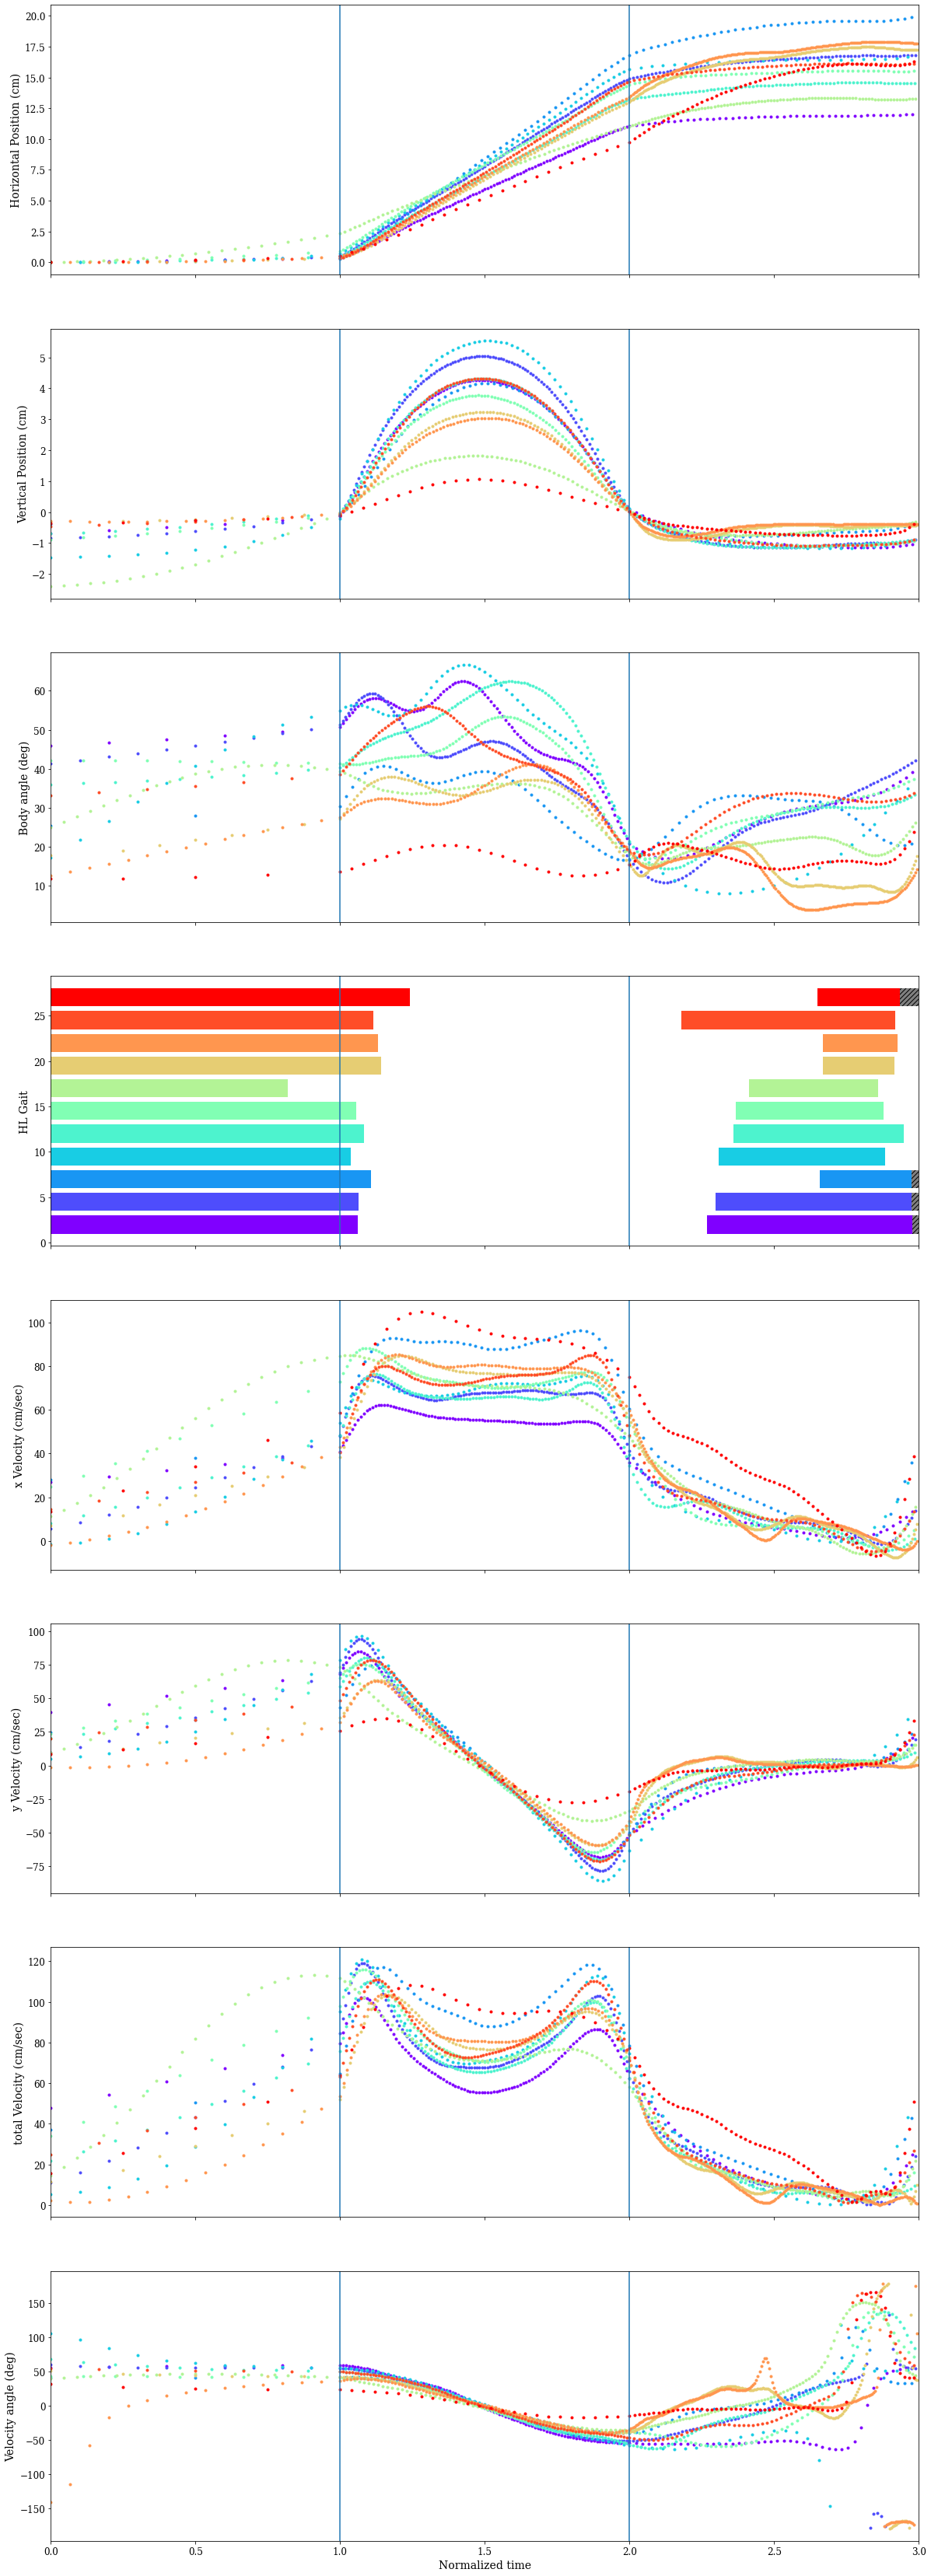

In [55]:
fig, ax = plt.subplots(nrows = 8, figsize = (20,60), sharex = True)

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

initgait = 1

ratio_b4 = 1
ratio_above=1
ratio_af = 1

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    min_timeb4 = time[b4_belowidx_s]
    max_timeb4 = time[b4_belowidx_e] - min_timeb4
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_timeb4)/max_timeb4 *ratio_b4
    
    ax[2].plot(below_b4_time, s_mnta[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[0].plot(below_b4_time, (s_mntx[b4_belowidx_s:b4_belowidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_b4_time, (s_mnty[b4_belowidx_s:b4_belowidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_b4_time, v_smntx[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[5].plot(below_b4_time, v_smnty[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[6].plot(below_b4_time, v_total[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[7].plot(below_b4_time, v_angle[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    
    #above
    min_timeab = time[aboveidx_s]
    max_timeab = time[aboveidx_e] - min_timeab
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_timeab)/max_timeab *ratio_above
    
    af_time = af_time + ratio_b4
    
    ax[2].plot(af_time, s_mnta[aboveidx_s:aboveidx_e], '.', c=c)
    ax[0].plot(af_time, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(af_time, (s_mnty[aboveidx_s:aboveidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(af_time, v_smntx[aboveidx_s:aboveidx_e], '.', c=c)
    ax[5].plot(af_time, v_smnty[aboveidx_s:aboveidx_e], '.', c=c)
    ax[6].plot(af_time, v_total[aboveidx_s:aboveidx_e], '.', c=c)
    ax[7].plot(af_time, v_angle[aboveidx_s:aboveidx_e], '.', c=c)
   
    #below_after
    min_timeaf = time[af_belowidx_s]
    max_timeaf = time[af_belowidx_e] - min_timeaf
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_timeaf)/max_timeaf *ratio_af
    
    below_af_time = below_af_time + ratio_above + ratio_b4#af_time[-1]
    
    ax[2].plot(below_af_time, s_mnta[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[0].plot(below_af_time, (s_mntx[af_belowidx_s:af_belowidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_af_time, (s_mnty[af_belowidx_s:af_belowidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_af_time, v_smntx[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[5].plot(below_af_time, v_smnty[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[6].plot(below_af_time, v_total[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[7].plot(below_af_time, v_angle[af_belowidx_s:af_belowidx_e], '.', c=c)
    
    
    #####################GAITS

    
    def scale_gaits(theval):
        start = theval[0]
        end = theval[0] + theval[1]
        
       # print(theval)
       # print(start, end)
        
        if  start <= b4_belowidx_e:
            start = (data['time'][start] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= start <= aboveidx_e:
            start = (data['time'][start] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= start:# <= af_belowidx_e:
            start = (data['time'][start] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    start = 0
            
        if  end <= b4_belowidx_e:
             end = (data['time'][end] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= end <= aboveidx_e:
             end = (data['time'][end] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= end: #<= af_belowidx_e:
             end = (data['time'][end] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    end = 0
        #print(start, end)
        return [start, end-start]
  
    #print('a', data['HL_t'])
    
    HL_a = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_a']]
    HL_t = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_t'] if x in data['frameno']]
   
   # print('b', HL_t)
    
    HL_a = [scale_gaits(x) for x in HL_a]
    HL_t = [scale_gaits(x) for x in HL_t]
   # print('c', HL_t)
    
    
    

        
    for t_val in HL_t:
        for a_val in HL_a:
            if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25/data['fps']:
                #print(t_val, a_val)
                start = (t_val[0] + t_val[1])
                end = a_val[0] - start
                    
                
                hatch_bar = ax[3].broken_barh([(start, end)], (initgait, 2), facecolors='gray', hatch='////')
        
        
    black_bar = ax[3].broken_barh(HL_a, (initgait, 2), facecolors=c)
    gray_bar = ax[3].broken_barh(HL_t, (initgait, 2), facecolors=c)
#     #ax[3].broken_barh(FL_a, (initgait + 2.5, 2), facecolors='black')
#     #ax[3].broken_barh(FL_t, (initgait + 2.5, 2), facecolors='gray')
    
    initgait = initgait + 2.5
    
    
    
    ###################Max velocity
#     #Idx of max velocity
#     #MaxVelIdx = np.where(v_total == np.max(v_total[aboveidx_s:aboveidx_e]))
#     #05/2021: the above gives incorrect place in rare case where velocity has 2 peaks
#     vtot = v_total*data['pxSVL']*frogsize
#     peak, k = signal.find_peaks(vtot[b4_belowidx_s:af_belowidx_e], prominence=data['fps'])
#     print(peak)
     
#     if len(peak) > 0:
#         #if len(peak) > 2:
#             #pass
#             #MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[1]])[0][0]
#         #else:
#          MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[0]])[0][0]
#     else:
#         MaxVelIdx= 5   
#     print('MaxVelIdx: %d' %MaxVelIdx)
#     fixed_maxidx = scale_gaits((MaxVelIdx, 0))
    
#     ax[6].axvline(fixed_maxidx[0], c = c)
#     ax[3].axvline(fixed_maxidx[0], c = c)
    
#     vtot = v_smnty*data['pxSVL']*frogsize
#     peak, k = signal.find_peaks(vtot[b4_belowidx_s:af_belowidx_e], prominence=data['fps'])
#     print(peak)
     
#     if len(peak) > 0:
#         #if len(peak) > 2:
#             #pass
#             #MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[1]])[0][0]
#         #else:
#          MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[0]])[0][0]
#     else:
#         MaxVelIdx= 5   
#     print('MaxVelIdx: %d' %MaxVelIdx)
#     fixed_maxidx = scale_gaits((MaxVelIdx, 0))
    
#     ax[5].axvline(fixed_maxidx[0], c = c)
#     ax[3].axvline(fixed_maxidx[0], c = c)
    
    

ax[0].set_ylabel("Horizontal Position (cm)")    
ax[1].set_ylabel("Vertical Position (cm)")    
ax[2].set_ylabel("Body angle (deg)")
ax[3].set_ylabel("HL Gait")
ax[4].set_ylabel("x Velocity (cm/sec)")
ax[5].set_ylabel("y Velocity (cm/sec)")
ax[6].set_ylabel("total Velocity (cm/sec)")
ax[7].set_ylabel('Velocity angle (deg)')
ax[7].set_xlabel('Normalized time')
#ax[7].set_xbound(0, 1)

#waterline
for axs in ax:
    axs.axvline(ratio_b4)
    axs.axvline(ratio_above + ratio_b4)
    axs.set_xbound(0, 3)
    
    
#max velocity?
# ax[4].axvline()
# ax[5]
# ax[6]

#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

In [ ]:
fig.savefig('210709_testplots/210708_normalized.png', transparent = True, dpi=1000)

In [282]:
ax[0].get_ylabel().replace(' ', '')

'HorizontalPosition(cm)'

In [ ]:
for frog 

In [46]:

for axs in [ax[3], ax[6]]:
    extent = axs.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("210709_testplots/%sCOLOR-maxline_NOWATER.png" %(axs.get_ylabel().replace(' ', '-').replace('/', '')), bbox_inches= extent.expanded(1.1, 1.2), transparent=True)

In [ ]:
#Frames propend to v_total

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


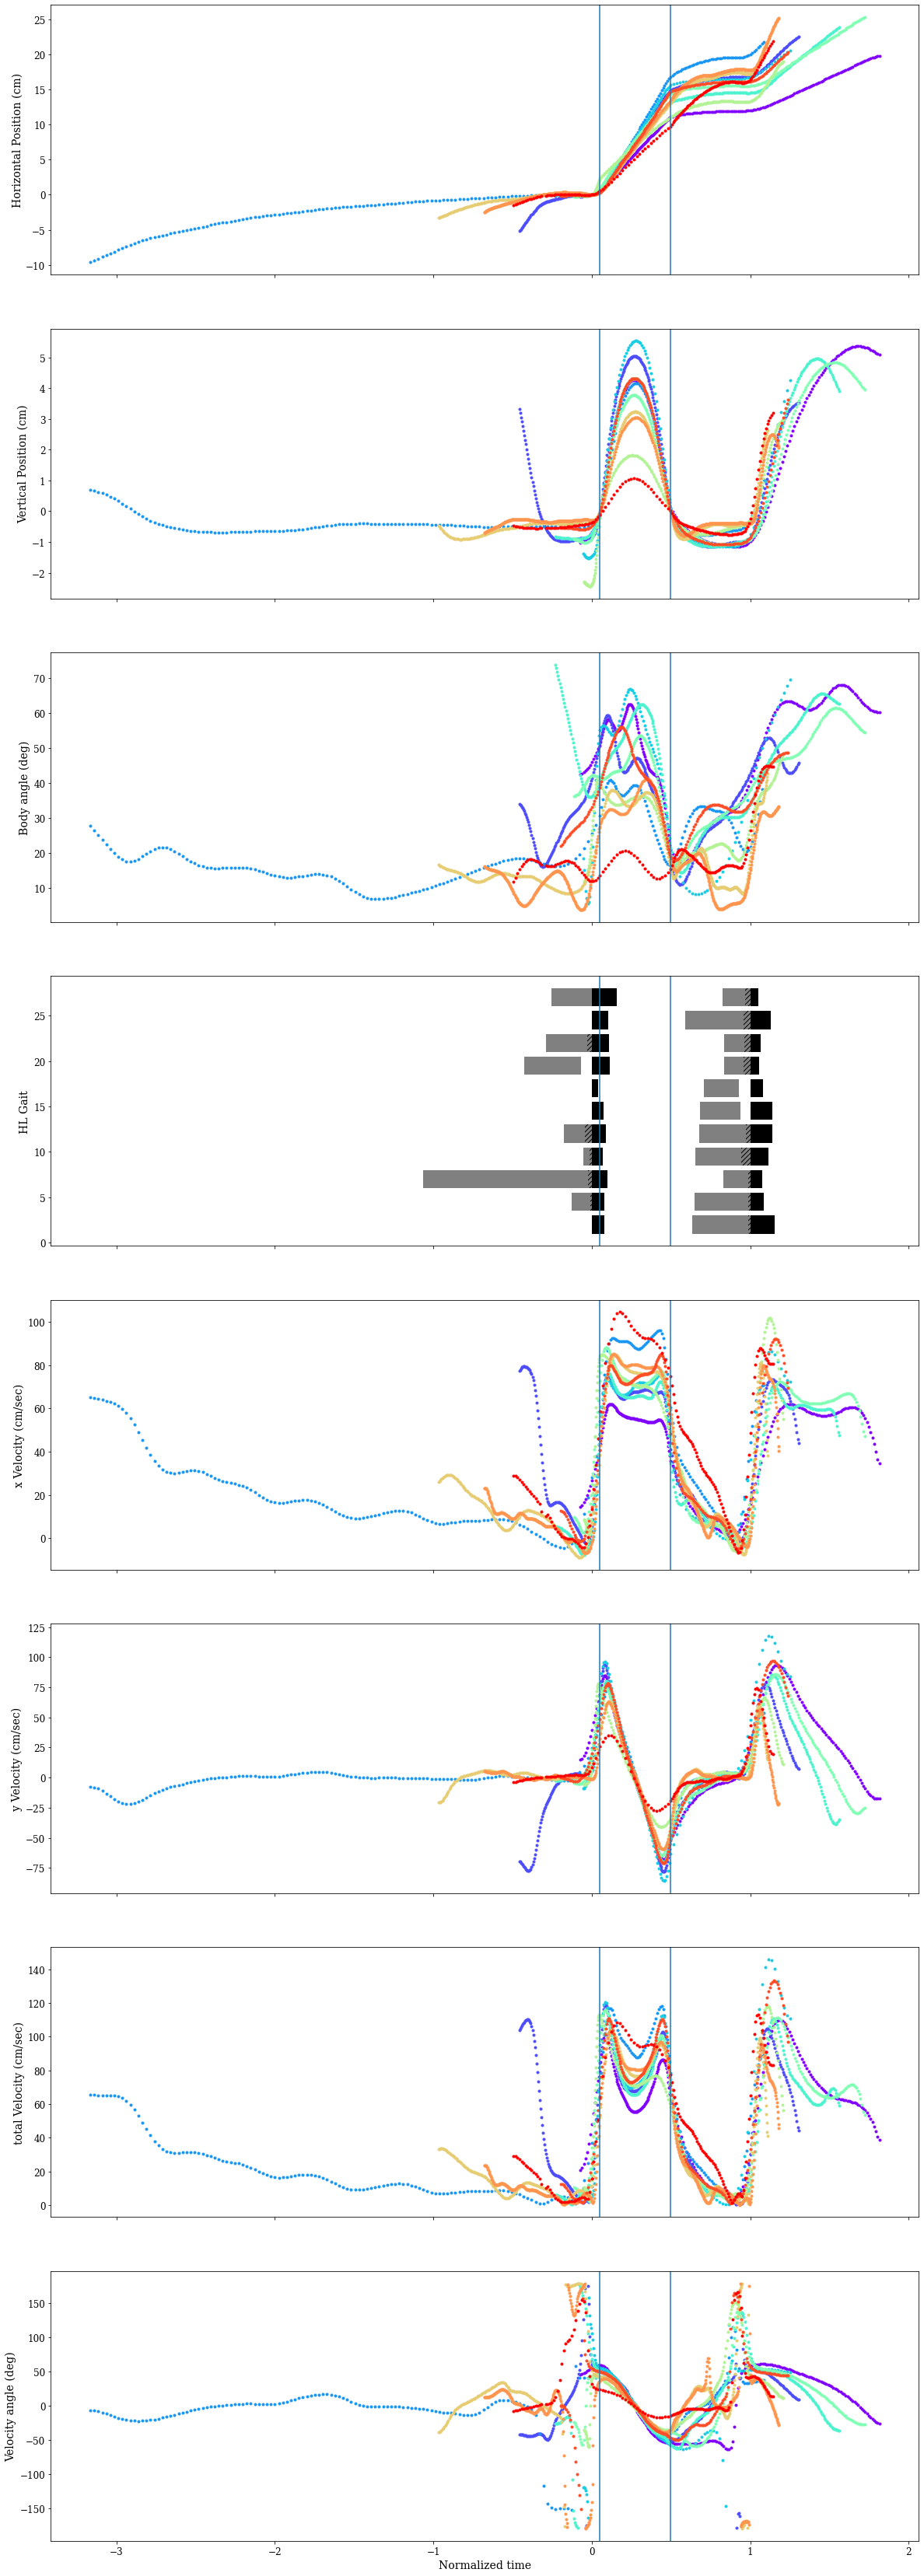

In [276]:
fig, ax = plt.subplots(nrows = 8, figsize = (20,60), sharex = True)

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

initgait = 1

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    min_timeb4 = time[b4_belowidx_s]
    max_timeb4 = time[b4_belowidx_e] - min_timeb4
    
    below_b4_time = (time[:b4_belowidx_e] - min_timeb4)/max_timeb4 *ratio_b4
    
    ax[2].plot(below_b4_time, s_mnta[:b4_belowidx_e], '.', c=c)
    ax[0].plot(below_b4_time, (s_mntx[:b4_belowidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_b4_time, (s_mnty[:b4_belowidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_b4_time, v_smntx[:b4_belowidx_e], '.', c=c)
    ax[5].plot(below_b4_time, v_smnty[:b4_belowidx_e], '.', c=c)
    ax[6].plot(below_b4_time, v_total[:b4_belowidx_e], '.', c=c)
    ax[7].plot(below_b4_time, v_angle[:b4_belowidx_e], '.', c=c)
    
    #above
    min_timeab = time[aboveidx_s]
    max_timeab = time[aboveidx_e] - min_timeab
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_timeab)/max_timeab *ratio_above
    
    af_time = af_time + ratio_b4
    
    ax[2].plot(af_time, s_mnta[aboveidx_s:aboveidx_e], '.', c=c)
    ax[0].plot(af_time, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(af_time, (s_mnty[aboveidx_s:aboveidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(af_time, v_smntx[aboveidx_s:aboveidx_e], '.', c=c)
    ax[5].plot(af_time, v_smnty[aboveidx_s:aboveidx_e], '.', c=c)
    ax[6].plot(af_time, v_total[aboveidx_s:aboveidx_e], '.', c=c)
    ax[7].plot(af_time, v_angle[aboveidx_s:aboveidx_e], '.', c=c)
   
    #below_after
    min_timeaf = time[af_belowidx_s]
    max_timeaf = time[af_belowidx_e] - min_timeaf
    
    below_af_time = (time[af_belowidx_s:] - min_timeaf)/max_timeaf *ratio_af
    
    below_af_time = below_af_time + ratio_above + ratio_b4#af_time[-1]
    
    ax[2].plot(below_af_time, s_mnta[af_belowidx_s:], '.', c=c)
    ax[0].plot(below_af_time, (s_mntx[af_belowidx_s:] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_af_time, (s_mnty[af_belowidx_s:])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_af_time, v_smntx[af_belowidx_s:], '.', c=c)
    ax[5].plot(below_af_time, v_smnty[af_belowidx_s:], '.', c=c)
    ax[6].plot(below_af_time, v_total[af_belowidx_s:], '.', c=c)
    ax[7].plot(below_af_time, v_angle[af_belowidx_s:], '.', c=c)
    
    
    #####################GAITS

    
    def scale_gaits(theval):
        start = theval[0]
        end = theval[0] + theval[1]
        
       # print(theval)
       # print(start, end)
        
        if  start <= b4_belowidx_e:
            start = (data['time'][start] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= start <= aboveidx_e:
            start = (data['time'][start] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= start:# <= af_belowidx_e:
            start = (data['time'][start] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    start = 0
            
        if  end <= b4_belowidx_e:
             end = (data['time'][end] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= end <= aboveidx_e:
             end = (data['time'][end] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= end: #<= af_belowidx_e:
             end = (data['time'][end] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    end = 0
        #print(start, end)
        return [start, end-start]
  
    #print('a', data['HL_t'])
    
    HL_a = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_a']]
    HL_t = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_t'] if x in data['frameno']]
   
   # print('b', HL_t)
    
    HL_a = [scale_gaits(x) for x in HL_a]
    HL_t = [scale_gaits(x) for x in HL_t]
   # print('c', HL_t)
    
    
    

        
    for t_val in HL_t:
        for a_val in HL_a:
            if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25/data['fps']:
                #print(t_val, a_val)
                start = (t_val[0] + t_val[1])
                end = a_val[0] - start
                    
                
                hatch_bar = ax[3].broken_barh([(start, end)], (initgait, 2), facecolors='gray', hatch='////')
        
        
    black_bar = ax[3].broken_barh(HL_a, (initgait, 2), facecolors='black')
    gray_bar = ax[3].broken_barh(HL_t, (initgait, 2), facecolors='gray')
#     #ax[3].broken_barh(FL_a, (initgait + 2.5, 2), facecolors='black')
#     #ax[3].broken_barh(FL_t, (initgait + 2.5, 2), facecolors='gray')
    
    initgait = initgait + 2.5    
    

ax[0].set_ylabel("Horizontal Position (cm)")    
ax[1].set_ylabel("Vertical Position (cm)")    
ax[2].set_ylabel("Body angle (deg)")
ax[3].set_ylabel("HL Gait")
ax[4].set_ylabel("x Velocity (cm/sec)")
ax[5].set_ylabel("y Velocity (cm/sec)")
ax[6].set_ylabel("total Velocity (cm/sec)")
ax[7].set_ylabel('Velocity angle (deg)')
ax[7].set_xlabel('Normalized time')
#ax[3].set_xbound(0, 1)

#waterline
for axs in ax:
    axs.axvline(ratio_b4)
    axs.axvline(ratio_above + ratio_b4)
    


#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

In [277]:
fig.savefig('210708_everythingnorm.png', transparent = True)

In [258]:
[(list(data['frameno']).index(x), y) for (x, y) in [(10, 20), (45, 20)] if x in data['frameno']]

[(18, 20)]

In [176]:
af_belowidx_s == aboveidx_e

True

In [177]:
below_af_time, af_time

(array([0.46705446, 0.47542791, 0.48380136, 0.49217481, 0.50054825,
        0.5089217 , 0.51729515, 0.5256686 , 0.53404204, 0.54241549,
        0.55078894, 0.55916239, 0.56753584, 0.57590928, 0.58428273,
        0.59265618, 0.60102963, 0.60940308, 0.61777652, 0.62614997,
        0.63452342, 0.64289687, 0.65127031, 0.65964376, 0.66801721,
        0.67639066, 0.68476411, 0.69313755, 0.701511  , 0.70988445,
        0.7182579 , 0.72663135, 0.73500479, 0.74337824, 0.75175169,
        0.76012514, 0.76849858, 0.77687203, 0.78524548, 0.79361893,
        0.80199238, 0.81036582, 0.81873927, 0.82711272, 0.83548617,
        0.84385962, 0.85223306, 0.86060651, 0.86897996, 0.87735341,
        0.88572685, 0.8941003 , 0.90247375, 0.9108472 , 0.91922065,
        0.92759409, 0.93596754, 0.94434099, 0.95271444, 0.96108788]),
 array([0.03798194, 0.05585996, 0.07373798, 0.091616  , 0.10949402,
        0.12737205, 0.14525007, 0.16312809, 0.18100611, 0.19888413,
        0.21676216, 0.23464018, 0.2525182 , 0.

In [25]:
time

array([0.104, 0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136,
       0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 , 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252, 0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 , 0.284,
       0.288, 0.292, 0.296, 0.3  , 0.304, 0.308, 0.312, 0.316, 0.32 ,
       0.324, 0.328, 0.332, 0.336, 0.34 , 0.344, 0.348, 0.352, 0.356,
       0.36 , 0.364, 0.368, 0.372, 0.376, 0.38 , 0.384, 0.388, 0.392,
       0.396, 0.4  , 0.404, 0.408, 0.412, 0.416, 0.42 , 0.424, 0.428,
       0.432, 0.436, 0.44 , 0.444, 0.448, 0.452, 0.456, 0.46 , 0.464,
       0.468, 0.472, 0.476, 0.48 , 0.484, 0.488, 0.492, 0.496, 0.5  ,
       0.504, 0.508, 0.512, 0.516, 0.52 , 0.524, 0.528, 0.532, 0.536,
       0.54 , 0.544, 0.548, 0.552, 0.556, 0.56 , 0.564, 0.568, 0.572,
       0.576, 0.58 , 0.584, 0.588, 0.592, 0.596, 0.6  , 0.604, 0.608,
       0.612, 0.616,

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


[Text(0, 0, 'B4_below'), Text(0, 0, 'above'), Text(0, 0, 'AF_below')]

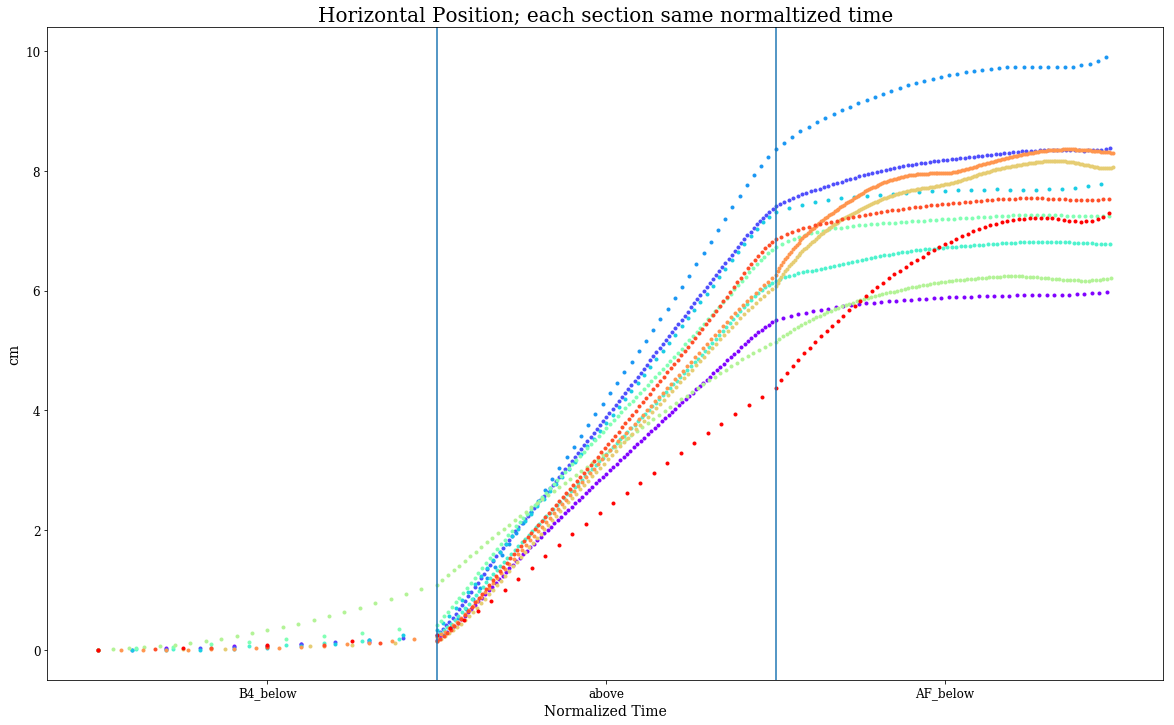

In [86]:
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    min_time = time[b4_belowidx_s]
    max_time = time[b4_belowidx_e] - min_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time, (s_mntx[b4_belowidx_s:b4_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
    
    #above
    min_time = time[aboveidx_s]
    max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time + 1.0, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL'], '.', c=c)
   
    #below_after
    min_time = time[af_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time + 2.0, (s_mntx[af_belowidx_s:af_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
ax.set_title("Horizontal Position; each section same normaltized time")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(1)
ax.axvline(2)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


[Text(0, 0, 'B4_below'), Text(0, 0, 'above'), Text(0, 0, 'AF_below')]

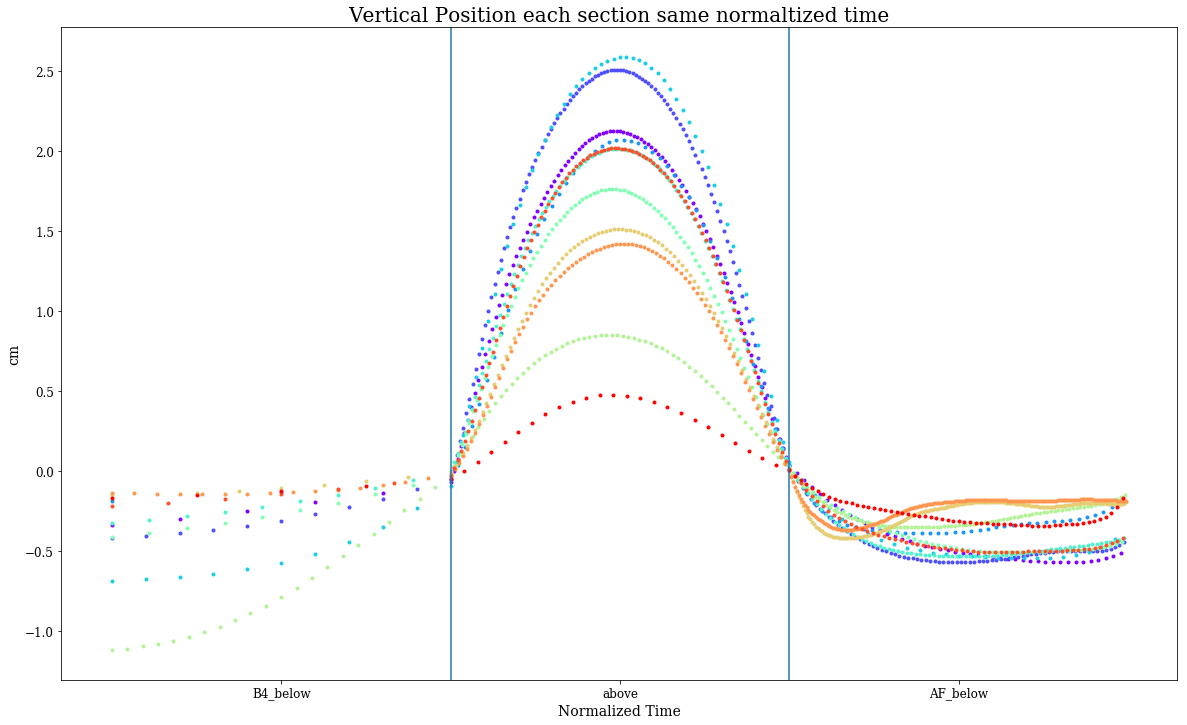

In [87]:
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    inity = s_mnty[b4_belowidx_s]
    #below_before
    min_time = time[b4_belowidx_s]
    max_time = time[b4_belowidx_e] - min_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time, s_mnty[b4_belowidx_s:b4_belowidx_e]/data['pxSVL'] , '.', c=c)
    
    #above
    min_time = time[aboveidx_s]
    max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time + 1.0, s_mnty[aboveidx_s:aboveidx_e]/data['pxSVL'], '.', c=c)
   
    #below_after
    min_time = time[af_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time + 2.0, s_mnty[af_belowidx_s:af_belowidx_e]/data['pxSVL'], '.', c=c)
ax.set_title("Vertical Position each section same normaltized time")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(1)
ax.axvline(2)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


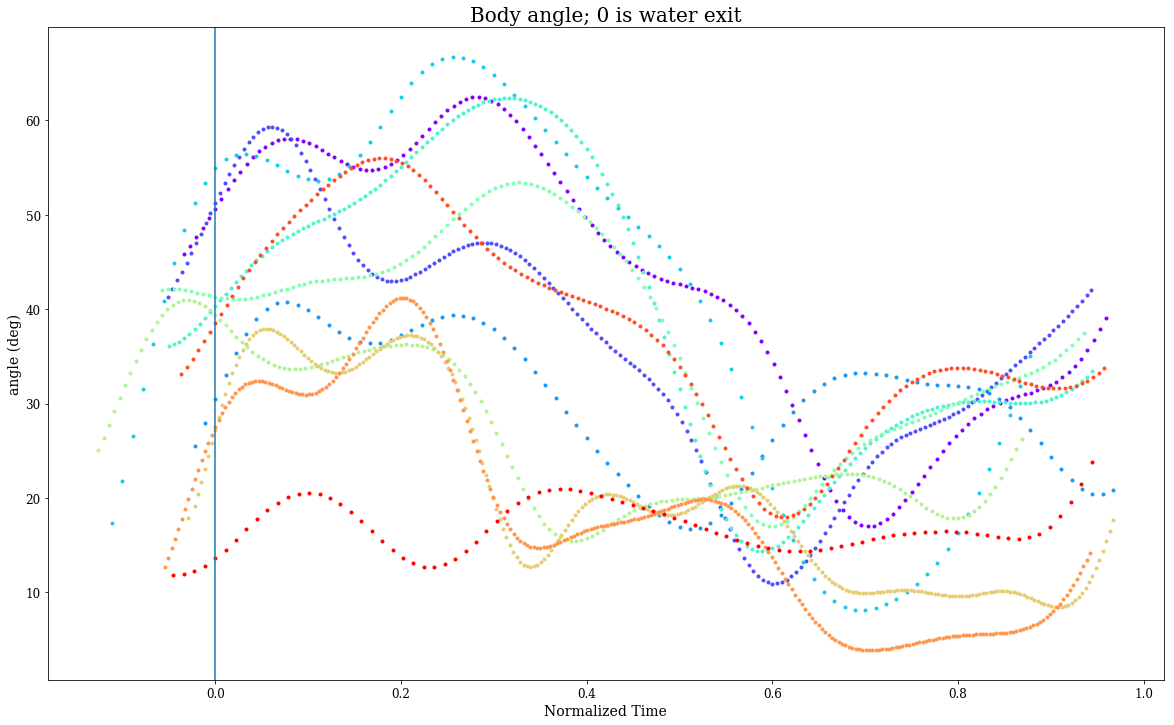

In [88]:
#All ormalized once, converged at water exit

fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    
    #below_before
    center_time = time[b4_belowidx_e]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
  
    c_t = (center_time - min_time)/max_time
        
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, s_mnta[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] -  min_time)/max_time
    
    ax.plot(af_time - c_t , s_mnta[aboveidx_s:aboveidx_e], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time - c_t , s_mnta[af_belowidx_s:af_belowidx_e], '.', c=c)
ax.set_title("Body angle; 0 is water exit")
ax.set_ylabel("angle (deg)")
ax.set_xlabel('Normalized Time')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


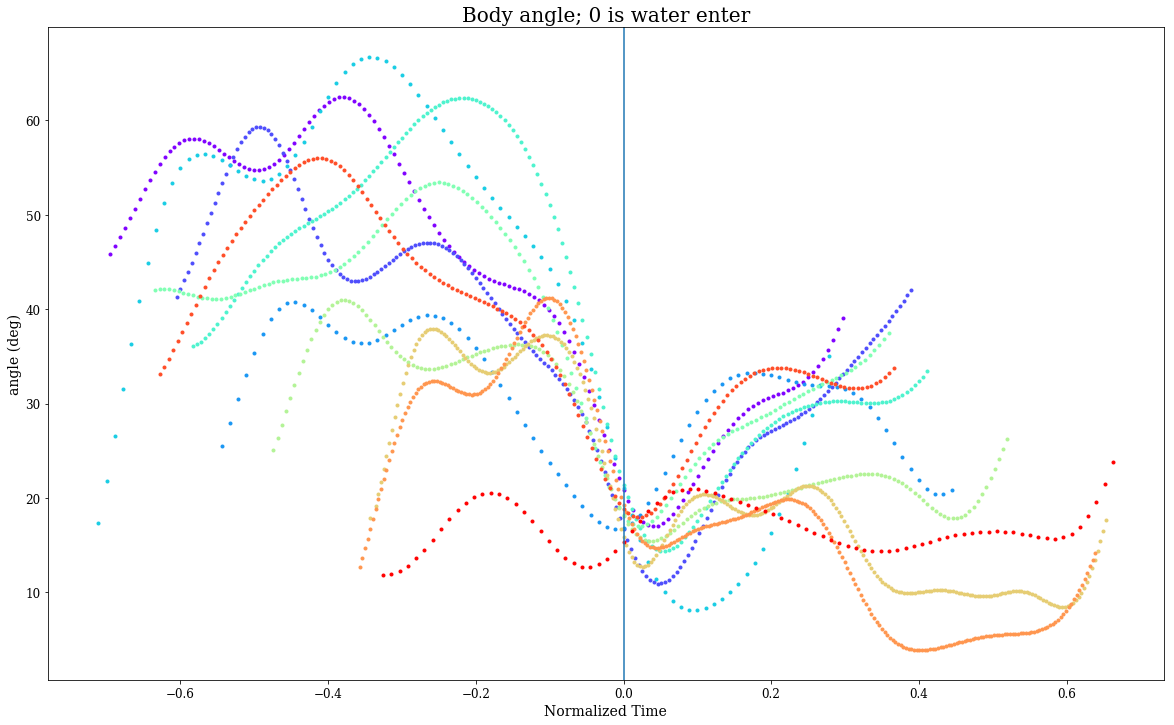

In [89]:
#All ormalized once, converged at water enter

fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    
    #below_before
    center_time = time[af_belowidx_s]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
  
    c_t = (center_time - min_time)/max_time
        
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, s_mnta[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] -  min_time)/max_time
    
    ax.plot(af_time - c_t , s_mnta[aboveidx_s:aboveidx_e], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time - c_t , s_mnta[af_belowidx_s:af_belowidx_e], '.', c=c)
ax.set_title("Body angle; 0 is water enter")
ax.set_ylabel("angle (deg)")
ax.set_xlabel('Normalized Time')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


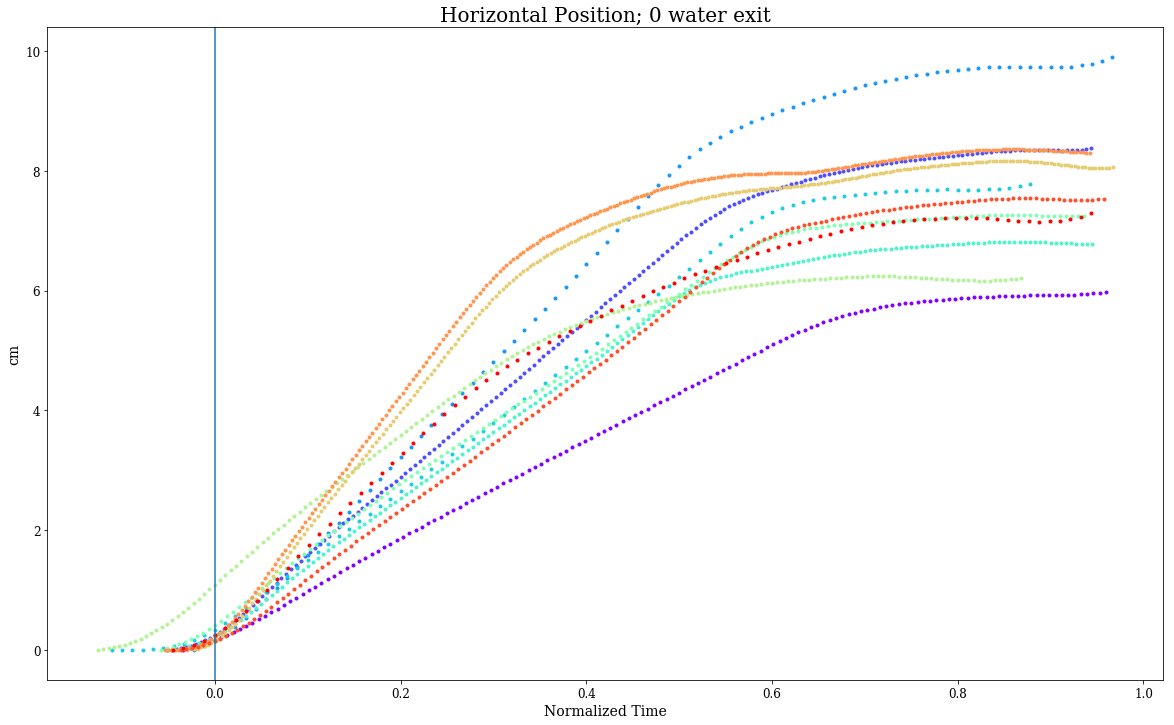

In [90]:
#water exit
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    center_time = time[b4_belowidx_e]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    c_t = (center_time - min_time)/max_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, (s_mntx[b4_belowidx_s:b4_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time - c_t, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL'], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time - c_t, (s_mntx[af_belowidx_s:af_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
ax.set_title("Horizontal Position; 0 water exit")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


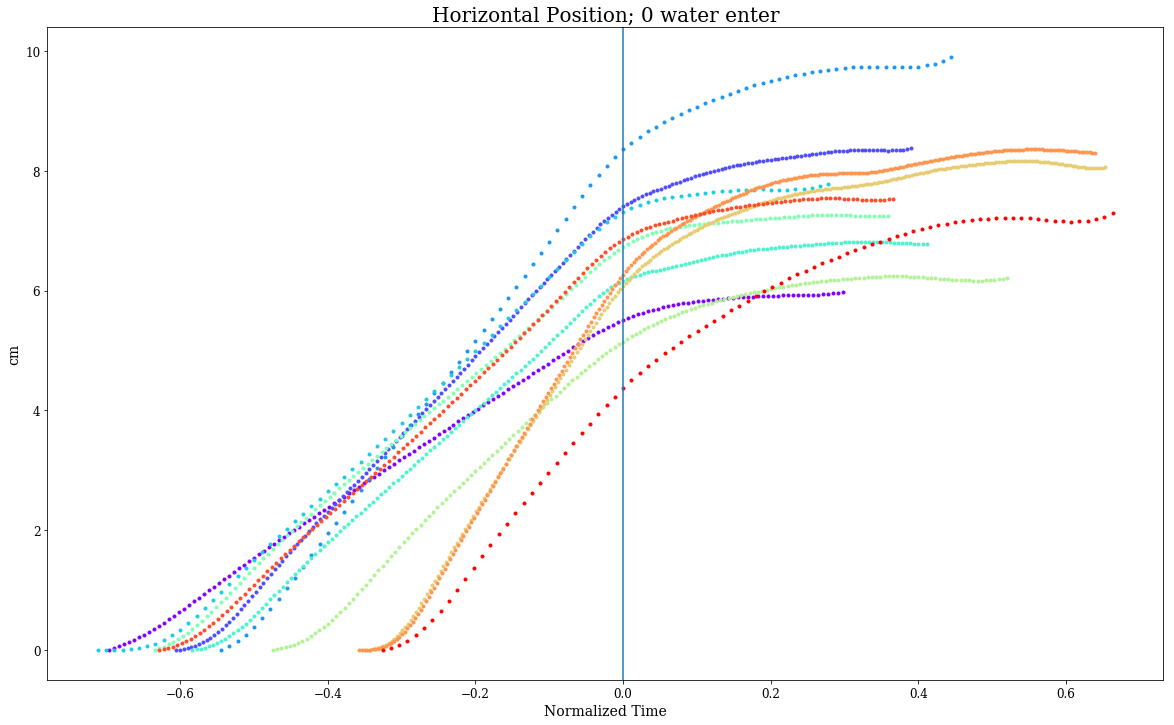

In [91]:
#water enter
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    center_time = time[af_belowidx_s]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    c_t = (center_time - min_time)/max_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, (s_mntx[b4_belowidx_s:b4_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time - c_t, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL'], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time - c_t, (s_mntx[af_belowidx_s:af_belowidx_e] - initx)/data['pxSVL'], '.', c=c)
ax.set_title("Horizontal Position; 0 water enter")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


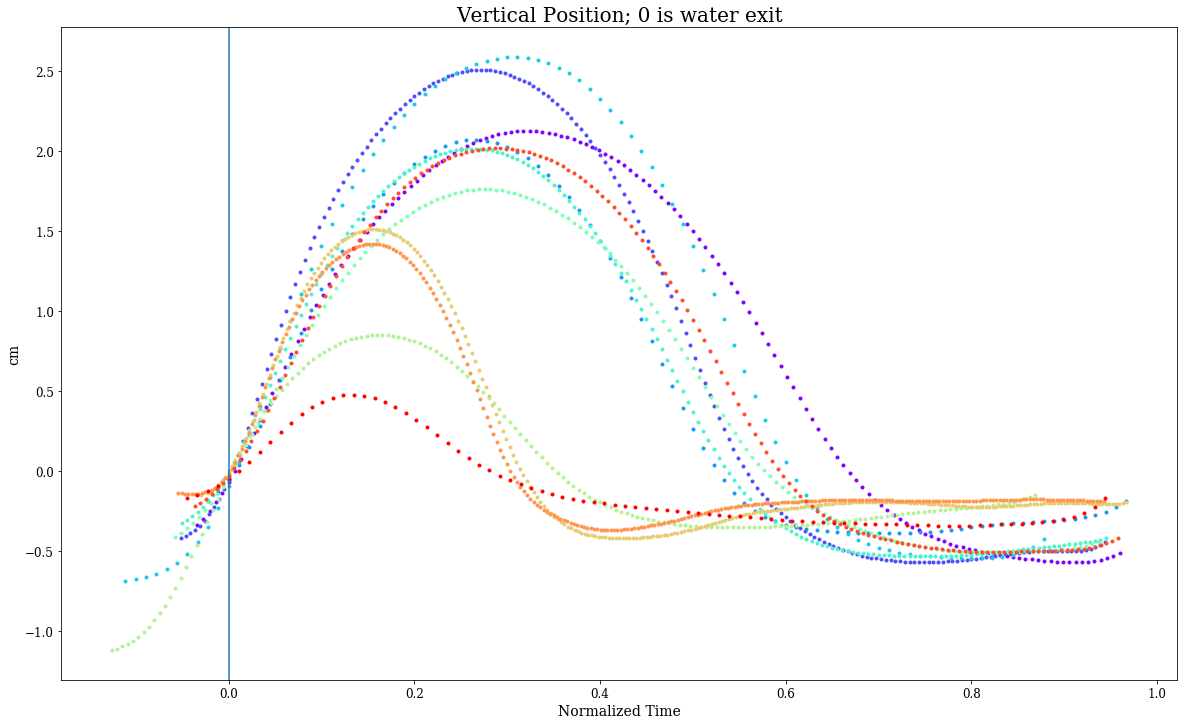

In [92]:
#water exit
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    inity = s_mnty[b4_belowidx_s]
    #below_before
    center_time = time[b4_belowidx_e]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    c_t = (center_time - min_time)/max_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, s_mnty[b4_belowidx_s:b4_belowidx_e]/data['pxSVL'] , '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time - c_t, s_mnty[aboveidx_s:aboveidx_e]/data['pxSVL'], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time  - c_t, s_mnty[af_belowidx_s:af_belowidx_e]/data['pxSVL'], '.', c=c)
ax.set_title("Vertical Position; 0 is water exit")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


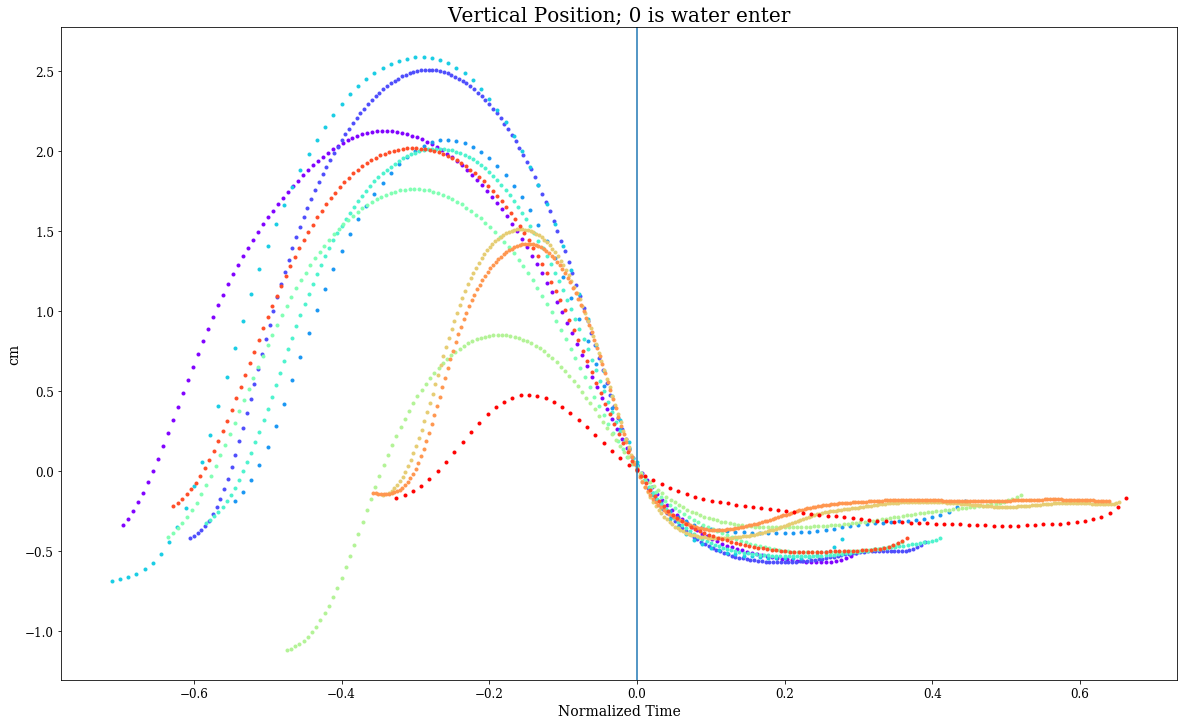

In [93]:
#water enter
fig, ax = plt.subplots(nrows = 1, figsize = (20,12))

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    
    time = data['time']
    frameno = data['frameno']
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    inity = s_mnty[b4_belowidx_s]
    #below_before
    center_time = time[af_belowidx_s]
    min_time = time[b4_belowidx_s]
    max_time = time[af_belowidx_e] - min_time
    
    c_t = (center_time - min_time)/max_time
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_time)/max_time
    
    ax.plot(below_b4_time - c_t, s_mnty[b4_belowidx_s:b4_belowidx_e]/data['pxSVL'] , '.', c=c)
    
    #above
    #min_time = time[aboveidx_s]
    #max_time = time[aboveidx_e] - min_time
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_time)/max_time
    
    ax.plot(af_time - c_t, s_mnty[aboveidx_s:aboveidx_e]/data['pxSVL'], '.', c=c)
   
    #below_after
    #min_time = time[af_belowidx_s]
    #max_time = time[af_belowidx_e] - min_time
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_time)/max_time
    
    ax.plot(below_af_time  - c_t, s_mnty[af_belowidx_s:af_belowidx_e]/data['pxSVL'], '.', c=c)
ax.set_title("Vertical Position; 0 is water enter")
ax.set_xlabel("Normalized Time")
ax.set_ylabel('cm')
ax.axvline(0)
#ax.axvline(2)
#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

In [56]:
from vidHandlr import *
from Photron_Handlr import *

In [57]:
aaa = vidHandlr('/mnt/wsl/PHYSICALDRIVE1/Acris spp/2015_11_15 Land Jumping/2015_11_15 Land Photron/AC04_4_201511_1659/AC04_4_201511_1659.cih')

In [59]:
aaa.type

'vid'

In [38]:
cih_parser('/mnt/wsl/PHYSICALDRIVE1/Acris spp/2015_11_15 Land Jumping/2015_11_15 Land Photron/AC04_4_201511_1659/AC04_4_201511_1659.cih')

{'Date': '2015/11/19',
 'Time': '16:57',
 'Camera Type': 'FASTCAM-APX RS model 250K',
 'Head Type': 'Unknown Child Device',
 'Camera ID': '11',
 'Camera Number': '0',
 'Head Number': '1',
 'Max Head Number': '1',
 'Scene Name': '',
 'User Defined Camera Name': '',
 'Session Number': '',
 'Date Record': 'Unknown',
 'Time Record': 'Unknown',
 'Trigger Time': '0',
 'Record Rate(fps)': '500',
 'Shutter Speed(s)': '1/1000',
 'Trigger Mode': 'End',
 'Original Total Frame': '18724',
 'Total Frame': '1103',
 'Start Frame': '-3826',
 'Correct Trigger Frame': '1',
 'Save Step': '1',
 'Image Width': '1024',
 'Image Height': '336',
 'Color Type': 'Mono',
 'Color Bit': '16',
 'File Format': 'MRaw',
 'EffectiveBit Depth': '10',
 'EffectiveBit Side': 'Lower',
 'Digits Of File Number': '6',
 'Comment Text': '',
 'Shutter Type2(nsec)': '1000000',
 'Edge Enhance': '0',
 'Pre LUT Mode': 'DEF1',
 'Pre LUT Brightness': '0',
 'Pre LUT Contrast': '0',
 'Pre LUT Gain': '1.0',
 'Pre LUT Gamma': '1.00',
 'Pre L

In [26]:
mnmap = get_menmap(cih_parser('/mnt/wsl/PHYSICALDRIVE1/Acris spp/2015_11_15 Land Jumping/2015_11_15 Land Photron/AC04_4_201511_1659/AC04_4_201511_1659.cih'))

In [48]:
mnmap[0].shape

(336, 1024)

In [49]:
import numpy as np
import cv2


# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('AC04_4_landjump.mp4',fourcc, 20.0, mnmap.shape[1:])

for i in range(mnmap.shape[0]):
    frame = mnmap[i]
    im = (frame/256.0).astype('uint8')
        
    out.write(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))

    cv2.imshow('frame',im)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) /tmp/pip-req-build-sl2aelck/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1
